TFM: Uso de árboles de decisión y MLP en
la predicción de energía renovable


CLARA MARTÍN PÉREZ

DNI: 70925201D

# Librerías utilizadas

In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 13.7 MB/s eta 0:00:00


In [3]:
pip install optuna[tfkeras]

In [6]:
pip install optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 2.7 MB/s eta 0:00:00


In [7]:
import itertools
import logging
import random

import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l1, l2

import optuna
from optuna.integration import TFKerasPruningCallback
import optuna.visualization as vis

In [ ]:
# import inspect
# from tensorflow.keras.losses import MeanAbsoluteError
# print(inspect.getsource(MeanAbsoluteError))

# MLP

In [8]:
df_completo = pd.read_csv('df_final.csv', sep=",")
df_completo['time'] = pd.to_datetime(df_completo['time'])
df_completo['verano'] = df_completo['time'].dt.month.isin([5, 6, 7, 8]).astype(int)

In [9]:
df_test = df_completo[df_completo['time'].dt.year == 2022]
df_trainval = df_completo[df_completo['time'].dt.year != 2022]

In [10]:
total_rows = len(df_completo)
print(f"Train: {len(df_trainval)} filas ({len(df_trainval)/total_rows:.2%})")
print(f"Test: {len(df_test)} filas ({len(df_test)/total_rows:.2%})")

Train: 51109 filas (85.38%)
Test: 8753 filas (14.62%)


In [11]:
variables_predictoras = [
            'cos_hora',
            'sin_hora',
            'verano',
            'u100_punto_1',
            'u100_punto_2',
            'u100_punto_3',
            'u100_punto_4',
            'u100_punto_5',
            'u100_punto_6',
            'u100_punto_7',
            'u100_punto_8',
            'u100_punto_9',
            'u100_punto_10',
            'u100_punto_11',
            'u100_punto_12',
            'u100_punto_13',
            'u100_punto_14',
            'u100_punto_15',
            'u100_punto_16',
            'v100_punto_1',
            'v100_punto_2',
            'v100_punto_3',
            'v100_punto_4',
            'v100_punto_5',
            'v100_punto_6',
            'v100_punto_7',
            'v100_punto_8',
            'v100_punto_9',
            'v100_punto_10',
            'v100_punto_11',
            'v100_punto_12',
            'v100_punto_13',
            'v100_punto_14',
            'v100_punto_15',
            'v100_punto_16',
            'mean_wind_speed',
            'mean_wind_cubed',
            'wind_speed_punto_1',
            'wind_speed_punto_2',
            'wind_speed_punto_3',
            'wind_speed_punto_4',
            'wind_speed_punto_5',
            'wind_speed_punto_6',
            'wind_speed_punto_7',
            'wind_speed_punto_8',
            'wind_speed_punto_9',
            'wind_speed_punto_10',
            'wind_speed_punto_11',
            'wind_speed_punto_12',
            'wind_speed_punto_13',
            'wind_speed_punto_14',
            'wind_speed_punto_15',
            'wind_speed_punto_16',
            'wind_cubed_punto_1',
            'wind_cubed_punto_2',
            'wind_cubed_punto_3',
            'wind_cubed_punto_4',
            'wind_cubed_punto_5',
            'wind_cubed_punto_6',
            'wind_cubed_punto_7',
            'wind_cubed_punto_8',
            'wind_cubed_punto_9',
            'wind_cubed_punto_10',
            'wind_cubed_punto_11',
            'wind_cubed_punto_12',
            'wind_cubed_punto_13',
            'wind_cubed_punto_14',
            'wind_cubed_punto_15',
            'wind_cubed_punto_16',
            'wind_direction_sin_punto_1',
            'wind_direction_sin_punto_2',
            'wind_direction_sin_punto_3',
            'wind_direction_sin_punto_4',
            'wind_direction_sin_punto_5',
            'wind_direction_sin_punto_6',
            'wind_direction_sin_punto_7',
            'wind_direction_sin_punto_8',
            'wind_direction_sin_punto_9',
            'wind_direction_sin_punto_10',
            'wind_direction_sin_punto_11',
            'wind_direction_sin_punto_12',
            'wind_direction_sin_punto_13',
            'wind_direction_sin_punto_14',
            'wind_direction_sin_punto_15',
            'wind_direction_sin_punto_16',
            'wind_direction_cos_punto_1',
            'wind_direction_cos_punto_2',
            'wind_direction_cos_punto_3',
            'wind_direction_cos_punto_4',
            'wind_direction_cos_punto_5',
            'wind_direction_cos_punto_6',
            'wind_direction_cos_punto_7',
            'wind_direction_cos_punto_8',
            'wind_direction_cos_punto_9',
            'wind_direction_cos_punto_10',
            'wind_direction_cos_punto_11',
            'wind_direction_cos_punto_12',
            'wind_direction_cos_punto_13',
            'wind_direction_cos_punto_14',
            'wind_direction_cos_punto_15',
            'wind_direction_cos_punto_16'
            ]

objetivo = ['Tanto por 1']

In [ ]:
len(variables_predictoras)

101

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

De nuevo, sigo el mismo procedimiento que en XGBOOST para la divisón de los datos.

In [18]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

def expand_blocks(block_indices):
    indices = []
    for b in block_indices:
        start = b * block_size
        indices.extend(range(start, start + block_size))
    return indices

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [ ]:
print(f"Train: {len(X_train)} filas ({len(X_train)/total_rows:.2%})")
print(f"Val: {len(X_val)} filas ({len(X_val)/total_rows:.2%})")
print(f"Test: {len(X_test)} filas ({len(X_test)/total_rows:.2%})")

Train: 43500 filas (72.67%)
Val: 7600 filas (12.70%)
Test: 8753 filas (14.62%)


In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Ajusto el scaler y transformo X
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Ajusto y transformo y
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [12]:
# Función que utilizaré luego
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# MLP OPTUNA

Optuna para obtener una primera aproximación de los valores de los hiperparámetros.

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.9 MB/s eta 0:00:00


In [ ]:
pip install optuna[tfkeras]

In [ ]:
pip install optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.9 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)

    hidden_layers = []
    dropouts = []

    for i in range(n_layers):
        units = trial.suggest_int(f'units_layer_{i+1}', 32, 256, step=32)
        reg_type = trial.suggest_categorical(f"reg_type_{i+1}", ["none", "l1", "l2", "dropout"])

        if reg_type == "l1":
            kernel_reg = l1(trial.suggest_float(f"l1_{i+1}", 1e-6, 1e-2, log=True))
            dropout = 0.0
        elif reg_type == "l2":
            kernel_reg = l2(trial.suggest_float(f"l2_{i+1}", 1e-6, 1e-2, log=True))
            dropout = 0.0
        elif reg_type == "dropout":
            kernel_reg = None
            dropout = trial.suggest_float(f"dropout_{i+1}", 0.1, 0.4, step=0.1)
        else:
            kernel_reg = None
            dropout = 0.0

        hidden_layers.append((units, kernel_reg))
        dropouts.append(dropout)

    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    patience = 10

    val_maes = []

    for i in range(3):
        semilla = np.random.randint(0, 10000)
        set_seeds(semilla)

        model = Sequential()
        model.add(Input(shape=(X_train_scaled.shape[1],)))

        for (units, reg), dropout in zip(hidden_layers, dropouts):
            model.add(Dense(units, activation='relu', kernel_regularizer=reg))
            if dropout > 0:
                model.add(Dropout(dropout))

        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae', metrics=['mae'])

        early_stop = EarlyStopping(patience=patience, restore_best_weights=True)
        pruning_cb = TFKerasPruningCallback(trial, "val_mae")

        model.fit(
            X_train_scaled, y_train_scaled,
            validation_data=(X_val_scaled, y_val_scaled),
            epochs=1000,
            batch_size=batch_size,
            callbacks=[early_stop, pruning_cb],
            verbose=0
        )

        y_pred_scaled = model.predict(X_val_scaled, verbose=0).flatten()
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        mae = mean_absolute_error(y_val, y_pred)
        val_maes.append(mae)

    return np.mean(val_maes)

In [ ]:
study = optuna.create_study(
    direction='minimize',
    study_name='MLP parámetros',
    storage='sqlite:///optuna_estudio_MLP.db',
    load_if_exists=True
)

study.optimize(objective, n_trials=200)
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print("Mejor MAE de validación: ", study.best_value)


[I 2025-05-22 14:59:51,790] Using an existing study with name 'MLP parámetros' instead of creating a new one.
[I 2025-05-22 14:59:56,341] Trial 190 pruned. Trial was pruned at epoch 0.
[I 2025-05-22 15:00:02,531] Trial 191 pruned. Trial was pruned at epoch 0.
[I 2025-05-22 15:00:13,569] Trial 192 pruned. Trial was pruned at epoch 2.
[I 2025-05-22 15:00:22,583] Trial 193 pruned. Trial was pruned at epoch 2.
[I 2025-05-22 15:02:03,660] Trial 194 pruned. Trial was pruned at epoch 33.
[I 2025-05-22 15:02:08,559] Trial 195 pruned. Trial was pruned at epoch 0.
[I 2025-05-22 15:02:12,258] Trial 196 pruned. Trial was pruned at epoch 0.
[I 2025-05-22 15:02:18,372] Trial 197 pruned. Trial was pruned at epoch 0.
[I 2025-05-22 15:02:22,038] Trial 198 pruned. Trial was pruned at epoch 0.
[I 2025-05-22 15:02:29,415] Trial 199 pruned. Trial was pruned at epoch 0.


Mejores hiperparámetros encontrados:
{'n_layers': 3, 'units_layer_1': 256, 'reg_type_1': 'l2', 'l2_1': 8.400451767968019e-05, 'units_layer_2': 96, 'reg_type_2': 'l1', 'l1_2': 0.0006107047994116768, 'units_layer_3': 64, 'reg_type_3': 'l2', 'l2_3': 0.00022882026942074295, 'learning_rate': 0.00012887933098133794, 'batch_size': 64}
Mejor MAE de validación:  0.07305874417454293


Etapa 145 (he hecho 200): Mejores hiperparámetros encontrados:
{'n_layers': 3, 'units_layer_1': 256, 'reg_type_1': 'l2', 'l2_1': 8.400451767968019e-05, 'units_layer_2': 96, 'reg_type_2': 'l1', 'l1_2': 0.0006107047994116768, 'units_layer_3': 64, 'reg_type_3': 'l2', 'l2_3': 0.00022882026942074295, 'learning_rate': 0.00012887933098133794, 'batch_size': 64}
Mejor MAE de validación:  0.07305874417454293

Visualización para ver el funcionamiento de del Prunner (el eje y representa val_mae y el eje x las épocas del entrenamiento)

In [ ]:
vis.plot_intermediate_values(study).show()

## Definición del modelo optuna

Defino el modelo obtenido con Optuna y lo evalúo.

In [22]:
class MAEOriginalCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, scaler_y):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scaler_y = scaler_y
        self.train_mae_original = []
        self.val_mae_original = []

    def on_epoch_end(self, epoch, logs=None):
        # Predicciones en escala original
        y_train_pred_scaled = self.model.predict(self.X_train, verbose=0)
        y_train_pred = self.scaler_y.inverse_transform(y_train_pred_scaled)
        train_mae = mean_absolute_error(self.y_train, y_train_pred)

        y_val_pred_scaled = self.model.predict(self.X_val, verbose=0)
        y_val_pred = self.scaler_y.inverse_transform(y_val_pred_scaled)
        val_mae = mean_absolute_error(self.y_val, y_val_pred)

        self.train_mae_original.append(train_mae)
        self.val_mae_original.append(val_mae)


MAEOriginalCallback calcula y guarda el MAE desescalado en cada epoch

In [ ]:
resultados = []

for i in range(1):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/5')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    mae_original_callback = MAEOriginalCallback(X_train_scaled, y_train, X_val_scaled, y_val, scaler_y)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop, mae_original_callback],
        verbose=0
    )


    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


# Métricas (en la escala original)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')


df_resultados = pd.DataFrame(resultados)
print("\n📌 RESULTADOS PROMEDIO sobre 5 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0686 | Val: 0.0702 | Test: 0.0726

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0686 ± nan
val_mae         = 0.0702 ± nan
test_mae        = 0.0726 ± nan
test_rmse       = 0.1093 ± nan
test_mse        = 0.0120 ± nan


In [ ]:
num_epocas_entrenadas = len(historia.history['loss'])
print(f'Se entrenó durante {num_epocas_entrenadas} épocas antes del EarlyStopping.')

Se entrenó durante 144 épocas antes del EarlyStopping.


In [ ]:
print(len(mae_original_callback.train_mae_original))

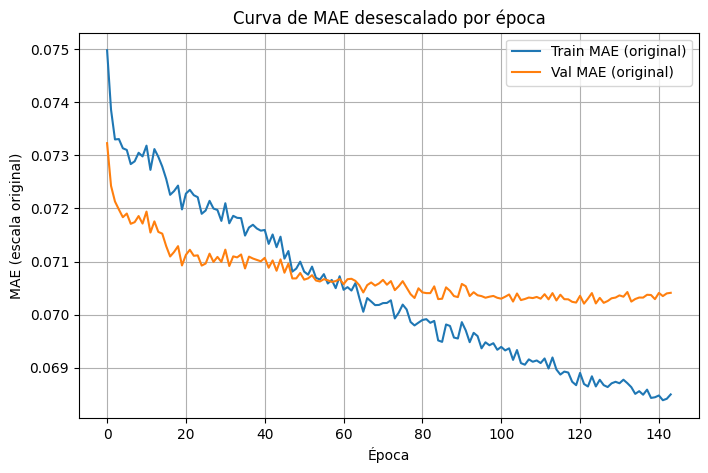

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(mae_original_callback.train_mae_original, label='Train MAE (original)')
plt.plot(mae_original_callback.val_mae_original, label='Val MAE (original)')
plt.xlabel('Época')
plt.ylabel('MAE (escala original)')
plt.title('Curva de MAE desescalado por época')
plt.legend()
plt.grid(True)
plt.show()

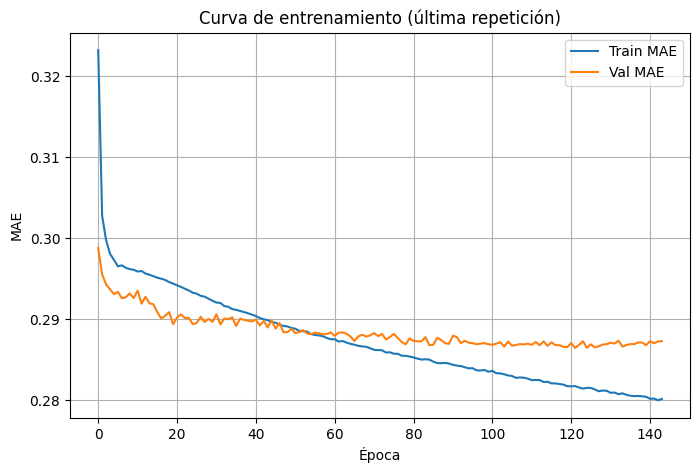

In [ ]:
historia_dict = historia.history

plt.figure(figsize=(8, 5))
plt.plot(historia_dict['mae'], label='Train MAE')
plt.plot(historia_dict['val_mae'], label='Val MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Curva de entrenamiento (última repetición)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def permutation_importance(model, X_val, y_val, metric=mean_absolute_error, n_repeats=5):
    baseline = metric(y_val, scaler_y.inverse_transform(model.predict(X_val)))
    importances = []

    for i in range(X_val.shape[1]):
        scores = []
        X_val_permuted = X_val.copy()
        for _ in range(n_repeats):
            np.random.shuffle(X_val_permuted[:, i])
            y_pred = scaler_y.inverse_transform(model.predict(X_val_permuted))
            score = metric(y_val, y_pred)
            scores.append(score)
        importance = np.mean(scores) - baseline
        importances.append(importance)

    return np.array(importances)

In [ ]:
importances = permutation_importance(modelo_mlp, X_val_scaled, y_val)
for name, imp in zip(variables_predictoras, importances):
    print(f"{name}: {imp:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━

In [ ]:
importancia_df = pd.DataFrame({
    'variable': variables_predictoras,
    'importancia': importances
})

pd.set_option('display.max_rows', None)

importancia_df = importancia_df.sort_values(by='importancia', ascending=False)

importancia_df

,variable,importancia
50,wind_speed_punto_13,0.015015
69,wind_cubed_punto_16,0.013708
53,wind_speed_punto_16,0.008056
54,wind_cubed_punto_1,0.007582
63,wind_cubed_punto_10,0.006850
61,wind_cubed_punto_8,0.006755
38,wind_speed_punto_1,0.006373
66,wind_cubed_punto_13,0.005903
56,wind_cubed_punto_3,0.005815
52,wind_speed_punto_15,0.003862


In [ ]:
pd.reset_option('display.max_rows')

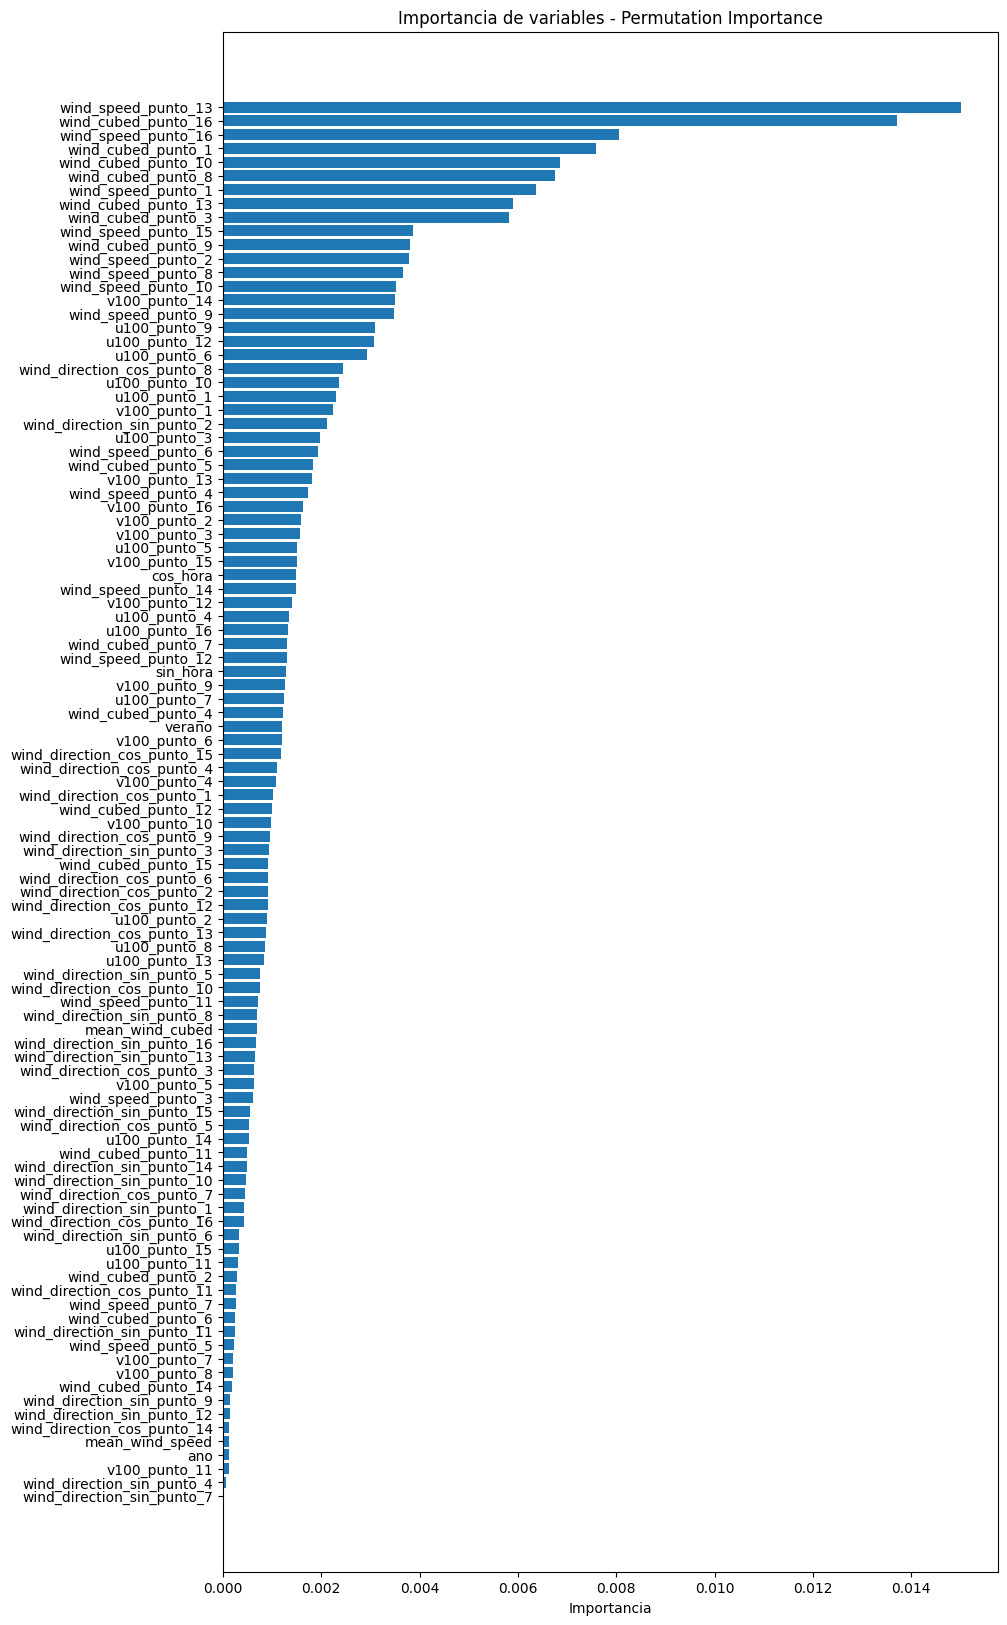

In [ ]:
importancia_df.sort_values(by='importancia', ascending=False, inplace=True)
plt.figure(figsize=(10, 20))
plt.barh(importancia_df['variable'], importancia_df['importancia'])
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de variables - Permutation Importance')
plt.show()

# Selección de variables predictoras

In [ ]:
variables_predictoras = [
            # 'cos_hora',
            # 'sin_hora',
            # 'verano',
            'u100_punto_1',
            'u100_punto_2',
            'u100_punto_3',
            'u100_punto_4',
            'u100_punto_5',
            'u100_punto_6',
            'u100_punto_7',
            'u100_punto_8',
            'u100_punto_9',
            'u100_punto_10',
            'u100_punto_11',
            'u100_punto_12',
            'u100_punto_13',
            'u100_punto_14',
            'u100_punto_15',
            'u100_punto_16',
            'v100_punto_1',
            'v100_punto_2',
            'v100_punto_3',
            'v100_punto_4',
            'v100_punto_5',
            'v100_punto_6',
            'v100_punto_7',
            'v100_punto_8',
            'v100_punto_9',
            'v100_punto_10',
            'v100_punto_11',
            'v100_punto_12',
            'v100_punto_13',
            'v100_punto_14',
            'v100_punto_15',
            'v100_punto_16',
            'mean_wind_speed',
            'mean_wind_cubed',
            'wind_speed_punto_1',
            'wind_speed_punto_2',
            'wind_speed_punto_3',
            'wind_speed_punto_4',
            'wind_speed_punto_5',
            'wind_speed_punto_6',
            'wind_speed_punto_7',
            'wind_speed_punto_8',
            'wind_speed_punto_9',
            'wind_speed_punto_10',
            'wind_speed_punto_11',
            'wind_speed_punto_12',
            'wind_speed_punto_13',
            'wind_speed_punto_14',
            'wind_speed_punto_15',
            'wind_speed_punto_16',
            'wind_cubed_punto_1',
            'wind_cubed_punto_2',
            'wind_cubed_punto_3',
            'wind_cubed_punto_4',
            'wind_cubed_punto_5',
            'wind_cubed_punto_6',
            'wind_cubed_punto_7',
            'wind_cubed_punto_8',
            'wind_cubed_punto_9',
            'wind_cubed_punto_10',
            'wind_cubed_punto_11',
            'wind_cubed_punto_12',
            'wind_cubed_punto_13',
            'wind_cubed_punto_14',
            'wind_cubed_punto_15',
            'wind_cubed_punto_16',
            'wind_direction_sin_punto_1',
            'wind_direction_sin_punto_2',
            'wind_direction_sin_punto_3',
            'wind_direction_sin_punto_4',
            'wind_direction_sin_punto_5',
            'wind_direction_sin_punto_6',
            'wind_direction_sin_punto_7',
            'wind_direction_sin_punto_8',
            'wind_direction_sin_punto_9',
            'wind_direction_sin_punto_10',
            'wind_direction_sin_punto_11',
            'wind_direction_sin_punto_12',
            'wind_direction_sin_punto_13',
            'wind_direction_sin_punto_14',
            'wind_direction_sin_punto_15',
            'wind_direction_sin_punto_16',
            'wind_direction_cos_punto_1',
            'wind_direction_cos_punto_2',
            'wind_direction_cos_punto_3',
            'wind_direction_cos_punto_4',
            'wind_direction_cos_punto_5',
            'wind_direction_cos_punto_6',
            'wind_direction_cos_punto_7',
            'wind_direction_cos_punto_8',
            'wind_direction_cos_punto_9',
            'wind_direction_cos_punto_10',
            'wind_direction_cos_punto_11',
            'wind_direction_cos_punto_12',
            'wind_direction_cos_punto_13',
            'wind_direction_cos_punto_14',
            'wind_direction_cos_punto_15',
            'wind_direction_cos_punto_16'
            ]

objetivo = ['Tanto por 1']

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n 🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')


df_resultados = pd.DataFrame(resultados)
print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0718 | Val: 0.0708 | Test: 0.0739

🔁 Repetición 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0713 | Val: 0.0703 | Test: 0.0733

🔁 Repetición 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0721 | Val: 0.0709 | Test: 0.0742

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0717 ± 0.0004
val_mae         = 0.0707 ± 0.0003
test_mae        = 0.0738 ± 0.0004
test_rmse       = 0.1104 ± 0.0007
test_mse        = 0.0122 ± 0.0002


COMBINACIONES FINALES:

- u, v, media, hora (36): 0.0732 ± 0.0003

- lo anterior + verano (37): 0.0730 ± 0.0003 5iter: 0.0730 ± 0.0004

- u, v, vel, medias (50):  0.0737 ± 0.0001

- u, v, vel, medias, hora (52): 0.0732 ± 0.0003

- u, v, vel, medias, verano (51): 0.0734 ± 0.0001

- u, v, vel, medias, ano (51): 0.0738 ± 0.0003

- u, v, vel, medias, hora y verano (53):   0.0730 ±0.00024

- u, v, cubo, vel, media, hora y verano(68) : 0.0731 ± 0.0006 creo q mal

- u, v, cubo, vel, hora y verano (67) : 0.0731 ± 0.0002

-  u, v, cubo, media, hora y verano (53): 0.0730 ± 0.0002

- u, v, vel, dir, medias hora y verano (85): 0.0730 ± 0.0003

- u, v, vel, dira hora y verano (83):  0.0731 ± 0.0001

- u, v, hora, verano (35): 0.0731 ± 0.0005



3 combinaciones tienen la misma métrica MAE sobre el test, escojo el modelo que tiene menos variables

# Añado las previsiones meteorológicas de la hora anterior y la siguiente

Defino distintos retardos de las previsiones metereológicas.

In [13]:
lags = range(-3, 4)
variables = [col for col in df_completo.columns if col.startswith(('u100', 'v100', 'mean_wind_speed', 'mean_wind_cubed'))]

for var in variables:
    for lag in lags:
        nombre_nueva_columna = f"{var}_lag{lag}"
        df_completo[nombre_nueva_columna] = df_completo[var].shift(lag)

df_completo = df_completo.dropna().reset_index(drop=True)

<ipython-input-13-3443090954>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_completo[nombre_nueva_columna] = df_completo[var].shift(lag)
<ipython-input-13-3443090954>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_completo[nombre_nueva_columna] = df_completo[var].shift(lag)
<ipython-input-13-3443090954>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

In [14]:
df_test = df_completo[df_completo['time'].dt.year == 2022]
df_trainval = df_completo[df_completo['time'].dt.year != 2022]

In [ ]:
total_rows = len(df_completo)
print(f"Train: {len(df_trainval)} filas ({len(df_trainval)/total_rows:.2%})")
print(f"Test: {len(df_test)} filas ({len(df_test)/total_rows:.2%})")

Train: 51103 filas (85.38%)
Test: 8753 filas (14.62%)


#### Anterior y siguiente

In [ ]:
variables_originales = [col for col in df_completo.columns if col.startswith(('u100', 'v100', 'mean_wind_speed', 'mean_wind_cubed'))
                        and '_lag' not in col]

lags = [-1, 0, 1]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras = variables_predictoras + ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)

['u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_3_lag-1', 'u100_punto_3_lag0', 'u100_punto_3_lag1', 'u100_punto_4_lag-1', 'u100_punto_4_lag0', 'u100_punto_4_lag1', 'u100_punto_5_lag-1', 'u100_punto_5_lag0', 'u100_punto_5_lag1', 'u100_punto_6_lag-1', 'u100_punto_6_lag0', 'u100_punto_6_lag1', 'u100_punto_7_lag-1', 'u100_punto_7_lag0', 'u100_punto_7_lag1', 'u100_punto_8_lag-1', 'u100_punto_8_lag0', 'u100_punto_8_lag1', 'u100_punto_9_lag-

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )


    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')

df_resultados = pd.DataFrame(resultados)

print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0673 | Val: 0.0675 | Test: 0.0701

🔁 Repetición 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 MAE Train: 0.0678 | Val: 0.0682 | Test: 0.0689

🔁 Repetición 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 MAE Train: 0.0681 | Val: 0.0688 | Test: 0.0691

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0677 ± 0.0004
val_mae         = 0.0681 ± 0.0007
test_mae        = 0.0694 ± 0.0007
test_rmse       = 0.1039 ± 0.0014
test_mse        = 0.0108 ± 0.0003


#### 2 anteriores y siguientes

In [ ]:
variables_originales = [col for col in df_completo.columns if col.startswith(('u100', 'v100', 'mean_wind_speed', 'mean_wind_cubed'))
                        and '_lag' not in col]

lags = [-2, -1, 0, 1, 2]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras = variables_predictoras + ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)

['u100_punto_1_lag-2', 'u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_1_lag2', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_2_lag-2', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_2_lag2', '

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [ ]:
len(variables_predictoras)

173

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')

df_resultados = pd.DataFrame(resultados)

print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0645 | Val: 0.0666 | Test: 0.0686

🔁 Repetición 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0670 | Val: 0.0676 | Test: 0.0680

🔁 Repetición 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0666 | Val: 0.0679 | Test: 0.0688

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0660 ± 0.0013
val_mae         = 0.0674 ± 0.0006
test_mae        = 0.0685 ± 0.0004
test_rmse       = 0.1026 ± 0.0008
test_mse        = 0.0105 ± 0.0002


#### 3 anteriores y siguientes

In [ ]:
variables_originales = [col for col in df_completo.columns if col.startswith(('u100', 'v100', 'mean_wind_speed', 'mean_wind_cubed'))
                        and '_lag' not in col]


lags = [-3, -2, -1, 0, 1, 2, 3]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras = variables_predictoras + ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)

['u100_punto_1_lag-3', 'u100_punto_1_lag-2', 'u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_1_lag2', 'u100_punto_1_lag3', 'u100_punto_10_lag-3', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_10_lag3', 'u100_punto_11_lag-3', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_11_lag3', 'u100_punto_12_lag-3', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_12_lag3', 'u100_punto_13_lag-3', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_13_lag3', 'u100_punto_14_lag-3', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_14_lag3', 'u100_punto_15_lag-3', 'u100_punto_15_lag-2', 'u100_punto_15_lag

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [ ]:
len(variables_predictoras)

241

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )


    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')

df_resultados = pd.DataFrame(resultados)

print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0665 | Val: 0.0669 | Test: 0.0698

🔁 Repetición 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0656 | Val: 0.0676 | Test: 0.0682

🔁 Repetición 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 MAE Train: 0.0661 | Val: 0.0684 | Test: 0.0682

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0661 ± 0.0004
val_mae         = 0.0676 ± 0.0007
test_mae        = 0.0687 ± 0.0009
test_rmse       = 0.1031 ± 0.0016
test_mse        = 0.0106 ± 0.0003


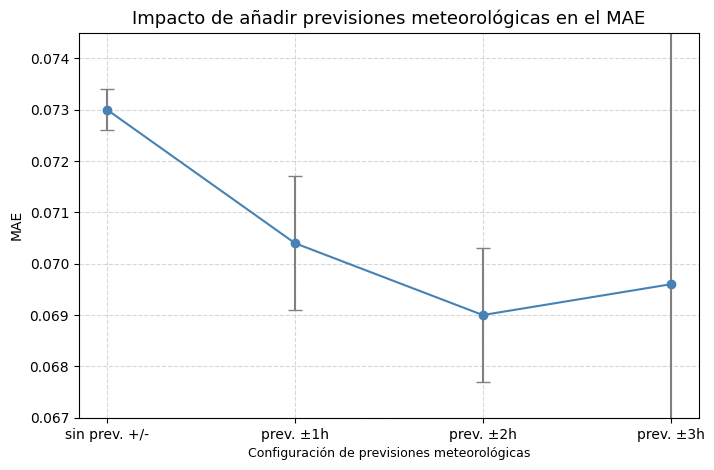

In [ ]:
configuraciones = ['sin prev. +/-', 'prev. ±1h', 'prev. ±2h', 'prev. ±3h']
mae_medias = [0.0730, 0.0694, 0.0685, 0.0687]
mae_error = [0.0004, 0.0007, 0.0004, 0.0009]

plt.figure(figsize=(8, 5))
plt.errorbar(configuraciones, mae_medias, yerr=mae_error, fmt='o-', capsize=5, color='steelblue', ecolor='gray')

plt.title('Impacto de añadir previsiones meteorológicas en el MAE', fontsize=13)
plt.ylabel('MAE')
plt.xlabel('Configuración de previsiones meteorológicas', fontsize=9)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0.067, 0.0745)
plt.show()


#### Anterior y siguiente (medio mapa)

In [ ]:
variables_originales = [col for col in df_completo.columns
                        if (
                            any(col.startswith(f"{var}_punto_{p}") for var in ['u100', 'v100'] for p in range(9, 17))
                            or col in ['mean_wind_speed', 'mean_wind_cubed']
                        )
                        and '_lag' not in col]

lags = [-1, 0, 1]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras += ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)


['u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [ ]:
len(variables_predictoras)

57

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )


    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')

df_resultados = pd.DataFrame(resultados)

print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0698 | Val: 0.0692 | Test: 0.0715

🔁 Repetición 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0687 | Val: 0.0683 | Test: 0.0702

🔁 Repetición 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0685 | Val: 0.0688 | Test: 0.0696

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0690 ± 0.0007
val_mae         = 0.0688 ± 0.0004
test_mae        = 0.0704 ± 0.0010
test_rmse       = 0.1053 ± 0.0011
test_mse        = 0.0111 ± 0.0002


#### 2 anteriores y siguientes (medio mapa)

In [ ]:
variables_originales = [col for col in df_completo.columns
                        if (
                            any(col.startswith(f"{var}_punto_{p}") for var in ['u100', 'v100'] for p in range(9, 17))
                            or col in ['mean_wind_speed', 'mean_wind_cubed']
                        )
                        and '_lag' not in col]

lags = [-2, -1, 0, 1, 2]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras += ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)

['u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [ ]:
len(variables_predictoras)

93

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )


    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')

df_resultados = pd.DataFrame(resultados)

print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0705 | Val: 0.0689 | Test: 0.0718

🔁 Repetición 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0680 | Val: 0.0679 | Test: 0.0694

🔁 Repetición 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0675 | Val: 0.0682 | Test: 0.0684

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0687 ± 0.0016
val_mae         = 0.0683 ± 0.0005
test_mae        = 0.0699 ± 0.0017
test_rmse       = 0.1042 ± 0.0015
test_mse        = 0.0109 ± 0.0003


#### 3 anteriores y siguientes (medio mapa)

In [ ]:
variables_originales = [col for col in df_completo.columns
                        if (
                            any(col.startswith(f"{var}_punto_{p}") for var in ['u100', 'v100'] for p in range(9, 17))
                            or col in ['mean_wind_speed', 'mean_wind_cubed']
                        )
                        and '_lag' not in col]

lags = [-3, -2, -1, 0, 1, 2, 3]
variables_predictoras = [f"{var}_lag{lag}" for var in variables_originales for lag in lags]
variables_predictoras += ['sin_hora', 'cos_hora', 'verano']
print(variables_predictoras)

['u100_punto_10_lag-3', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_10_lag3', 'u100_punto_11_lag-3', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_11_lag3', 'u100_punto_12_lag-3', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_12_lag3', 'u100_punto_13_lag-3', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_13_lag3', 'u100_punto_14_lag-3', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_14_lag3', 'u100_punto_15_lag-3', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_15_lag3', 'u100_punto_16_lag-3', 'u100_punto_16_lag-2', 'u100_punto

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [ ]:
len(variables_predictoras)

129

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )


    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')

df_resultados = pd.DataFrame(resultados)

print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0689 | Val: 0.0683 | Test: 0.0708

🔁 Repetición 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0680 | Val: 0.0677 | Test: 0.0690

🔁 Repetición 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0681 | Val: 0.0682 | Test: 0.0688

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0683 ± 0.0004
val_mae         = 0.0681 ± 0.0003
test_mae        = 0.0695 ± 0.0011
test_rmse       = 0.1035 ± 0.0011
test_mse        = 0.0107 ± 0.0002


### Validación cruzada

Los resultados son bastante parecidos así que prubeo a aplicar una validación cruzada, de forma que cada vez se asigna como test un año.

In [ ]:
def evaluar_variables(df_completo, variables_predictoras, anos, n_iter):
    resultados_por_ano = []

    for test_year in anos:
        df_test = df_completo[df_completo['time'].dt.year == test_year]
        df_trainval = df_completo[df_completo['time'].dt.year != test_year]

        X_trainval = df_trainval[variables_predictoras]
        y_trainval = df_trainval['Tanto por 1']

        X_test = df_test[variables_predictoras]
        y_test = df_test['Tanto por 1']

        block_size = 100
        val_fraction = 0.15
        n_blocks = len(X_trainval) // block_size
        blocks = np.arange(n_blocks)

        np.random.seed(42)
        np.random.shuffle(blocks)
        n_val_blocks = int(n_blocks * val_fraction)
        val_blocks = blocks[:n_val_blocks]
        train_blocks = blocks[n_val_blocks:]

        train_indices = expand_blocks(train_blocks)
        val_indices = expand_blocks(val_blocks)

        X_train = X_trainval.iloc[train_indices]
        y_train = y_trainval.iloc[train_indices]
        X_val = X_trainval.iloc[val_indices]
        y_val = y_trainval.iloc[val_indices]

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_val_scaled = scaler_X.transform(X_val)
        X_test_scaled = scaler_X.transform(X_test)

        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
        y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

        maes_test = []

        for i in range(n_iter):
            semilla = np.random.randint(0, 10000)
            set_seeds(semilla)

            modelo_mlp = Sequential([
                Input(shape=(X_train_scaled.shape[1],)),
                Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
                Dense(96, activation='relu', kernel_regularizer=l1(0.0006107047994116768)),
                Dense(64, activation='relu', kernel_regularizer=l2(0.00022882026942074295)),
                Dense(1)
            ])

            optimizer = Adam(learning_rate=0.00012887933098133794)
            modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

            early_stop = EarlyStopping(patience=10, restore_best_weights=True)

            modelo_mlp.fit(
                X_train_scaled, y_train_scaled,
                validation_data=(X_val_scaled, y_val_scaled),
                epochs=1000,
                batch_size=64,
                callbacks=[early_stop],
                verbose=0
            )

            y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
            y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

            test_mae = mean_absolute_error(y_test, y_test_pred)
            maes_test.append(test_mae)

        media_mae_test = np.mean(maes_test)
        resultados_por_ano.append(media_mae_test)

        print(f'Año {test_year}: MAE medio = {media_mae_test:.4f}, desvío iteraciones = {np.std(maes_test):.4f}')

    media_total = np.mean(resultados_por_ano)
    std_total = np.std(resultados_por_ano)
    print(f'\nResultados para variables: {variables_predictoras}')
    print(f'Media de MAEs anuales: {media_total:.4f}')
    print(f'Desviación típica de MAEs anuales: {std_total:.4f}')

    return resultados_por_ano

In [ ]:
anos = [2020, 2023, 2022]
variables_predictoras1 = ['u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_3_lag-1', 'u100_punto_3_lag0', 'u100_punto_3_lag1', 'u100_punto_4_lag-1', 'u100_punto_4_lag0', 'u100_punto_4_lag1', 'u100_punto_5_lag-1', 'u100_punto_5_lag0', 'u100_punto_5_lag1', 'u100_punto_6_lag-1', 'u100_punto_6_lag0', 'u100_punto_6_lag1', 'u100_punto_7_lag-1', 'u100_punto_7_lag0', 'u100_punto_7_lag1', 'u100_punto_8_lag-1', 'u100_punto_8_lag0', 'u100_punto_8_lag1', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'v100_punto_1_lag-1', 'v100_punto_1_lag0', 'v100_punto_1_lag1', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_2_lag-1', 'v100_punto_2_lag0', 'v100_punto_2_lag1', 'v100_punto_3_lag-1', 'v100_punto_3_lag0', 'v100_punto_3_lag1', 'v100_punto_4_lag-1', 'v100_punto_4_lag0', 'v100_punto_4_lag1', 'v100_punto_5_lag-1', 'v100_punto_5_lag0', 'v100_punto_5_lag1', 'v100_punto_6_lag-1', 'v100_punto_6_lag0', 'v100_punto_6_lag1', 'v100_punto_7_lag-1', 'v100_punto_7_lag0', 'v100_punto_7_lag1', 'v100_punto_8_lag-1', 'v100_punto_8_lag0', 'v100_punto_8_lag1', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'sin_hora', 'cos_hora', 'verano']
variables_predictoras2 = ['u100_punto_1_lag-2', 'u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_1_lag2', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_2_lag-2', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_2_lag2', 'u100_punto_3_lag-2', 'u100_punto_3_lag-1', 'u100_punto_3_lag0', 'u100_punto_3_lag1', 'u100_punto_3_lag2', 'u100_punto_4_lag-2', 'u100_punto_4_lag-1', 'u100_punto_4_lag0', 'u100_punto_4_lag1', 'u100_punto_4_lag2', 'u100_punto_5_lag-2', 'u100_punto_5_lag-1', 'u100_punto_5_lag0', 'u100_punto_5_lag1', 'u100_punto_5_lag2', 'u100_punto_6_lag-2', 'u100_punto_6_lag-1', 'u100_punto_6_lag0', 'u100_punto_6_lag1', 'u100_punto_6_lag2', 'u100_punto_7_lag-2', 'u100_punto_7_lag-1', 'u100_punto_7_lag0', 'u100_punto_7_lag1', 'u100_punto_7_lag2', 'u100_punto_8_lag-2', 'u100_punto_8_lag-1', 'u100_punto_8_lag0', 'u100_punto_8_lag1', 'u100_punto_8_lag2', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'v100_punto_1_lag-2', 'v100_punto_1_lag-1', 'v100_punto_1_lag0', 'v100_punto_1_lag1', 'v100_punto_1_lag2', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag2', 'v100_punto_11_lag-2', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_11_lag2', 'v100_punto_12_lag-2', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_12_lag2', 'v100_punto_13_lag-2', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_13_lag2', 'v100_punto_14_lag-2', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_14_lag2', 'v100_punto_15_lag-2', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_15_lag2', 'v100_punto_16_lag-2', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_16_lag2', 'v100_punto_2_lag-2', 'v100_punto_2_lag-1', 'v100_punto_2_lag0', 'v100_punto_2_lag1', 'v100_punto_2_lag2', 'v100_punto_3_lag-2', 'v100_punto_3_lag-1', 'v100_punto_3_lag0', 'v100_punto_3_lag1', 'v100_punto_3_lag2', 'v100_punto_4_lag-2', 'v100_punto_4_lag-1', 'v100_punto_4_lag0', 'v100_punto_4_lag1', 'v100_punto_4_lag2', 'v100_punto_5_lag-2', 'v100_punto_5_lag-1', 'v100_punto_5_lag0', 'v100_punto_5_lag1', 'v100_punto_5_lag2', 'v100_punto_6_lag-2', 'v100_punto_6_lag-1', 'v100_punto_6_lag0', 'v100_punto_6_lag1', 'v100_punto_6_lag2', 'v100_punto_7_lag-2', 'v100_punto_7_lag-1', 'v100_punto_7_lag0', 'v100_punto_7_lag1', 'v100_punto_7_lag2', 'v100_punto_8_lag-2', 'v100_punto_8_lag-1', 'v100_punto_8_lag0', 'v100_punto_8_lag1', 'v100_punto_8_lag2', 'v100_punto_9_lag-2', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'v100_punto_9_lag2', 'mean_wind_speed_lag-2', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_speed_lag2', 'mean_wind_cubed_lag-2', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'mean_wind_cubed_lag2', 'sin_hora', 'cos_hora', 'verano']
variables_predictoras3 = ['u100_punto_1_lag-3', 'u100_punto_1_lag-2', 'u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_1_lag2', 'u100_punto_1_lag3', 'u100_punto_10_lag-3', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_10_lag3', 'u100_punto_11_lag-3', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_11_lag3', 'u100_punto_12_lag-3', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_12_lag3', 'u100_punto_13_lag-3', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_13_lag3', 'u100_punto_14_lag-3', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_14_lag3', 'u100_punto_15_lag-3', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_15_lag3', 'u100_punto_16_lag-3', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_16_lag3', 'u100_punto_2_lag-3', 'u100_punto_2_lag-2', 'u100_punto_2_lag-1', 'u100_punto_2_lag0', 'u100_punto_2_lag1', 'u100_punto_2_lag2', 'u100_punto_2_lag3', 'u100_punto_3_lag-3', 'u100_punto_3_lag-2', 'u100_punto_3_lag-1', 'u100_punto_3_lag0', 'u100_punto_3_lag1', 'u100_punto_3_lag2', 'u100_punto_3_lag3', 'u100_punto_4_lag-3', 'u100_punto_4_lag-2', 'u100_punto_4_lag-1', 'u100_punto_4_lag0', 'u100_punto_4_lag1', 'u100_punto_4_lag2', 'u100_punto_4_lag3', 'u100_punto_5_lag-3', 'u100_punto_5_lag-2', 'u100_punto_5_lag-1', 'u100_punto_5_lag0', 'u100_punto_5_lag1', 'u100_punto_5_lag2', 'u100_punto_5_lag3', 'u100_punto_6_lag-3', 'u100_punto_6_lag-2', 'u100_punto_6_lag-1', 'u100_punto_6_lag0', 'u100_punto_6_lag1', 'u100_punto_6_lag2', 'u100_punto_6_lag3', 'u100_punto_7_lag-3', 'u100_punto_7_lag-2', 'u100_punto_7_lag-1', 'u100_punto_7_lag0', 'u100_punto_7_lag1', 'u100_punto_7_lag2', 'u100_punto_7_lag3', 'u100_punto_8_lag-3', 'u100_punto_8_lag-2', 'u100_punto_8_lag-1', 'u100_punto_8_lag0', 'u100_punto_8_lag1', 'u100_punto_8_lag2', 'u100_punto_8_lag3', 'u100_punto_9_lag-3', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'u100_punto_9_lag3', 'v100_punto_1_lag-3', 'v100_punto_1_lag-2', 'v100_punto_1_lag-1', 'v100_punto_1_lag0', 'v100_punto_1_lag1', 'v100_punto_1_lag2', 'v100_punto_1_lag3', 'v100_punto_10_lag-3', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag2', 'v100_punto_10_lag3', 'v100_punto_11_lag-3', 'v100_punto_11_lag-2', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_11_lag2', 'v100_punto_11_lag3', 'v100_punto_12_lag-3', 'v100_punto_12_lag-2', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_12_lag2', 'v100_punto_12_lag3', 'v100_punto_13_lag-3', 'v100_punto_13_lag-2', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_13_lag2', 'v100_punto_13_lag3', 'v100_punto_14_lag-3', 'v100_punto_14_lag-2', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_14_lag2', 'v100_punto_14_lag3', 'v100_punto_15_lag-3', 'v100_punto_15_lag-2', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_15_lag2', 'v100_punto_15_lag3', 'v100_punto_16_lag-3', 'v100_punto_16_lag-2', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_16_lag2', 'v100_punto_16_lag3', 'v100_punto_2_lag-3', 'v100_punto_2_lag-2', 'v100_punto_2_lag-1', 'v100_punto_2_lag0', 'v100_punto_2_lag1', 'v100_punto_2_lag2', 'v100_punto_2_lag3', 'v100_punto_3_lag-3', 'v100_punto_3_lag-2', 'v100_punto_3_lag-1', 'v100_punto_3_lag0', 'v100_punto_3_lag1', 'v100_punto_3_lag2', 'v100_punto_3_lag3', 'v100_punto_4_lag-3', 'v100_punto_4_lag-2', 'v100_punto_4_lag-1', 'v100_punto_4_lag0', 'v100_punto_4_lag1', 'v100_punto_4_lag2', 'v100_punto_4_lag3', 'v100_punto_5_lag-3', 'v100_punto_5_lag-2', 'v100_punto_5_lag-1', 'v100_punto_5_lag0', 'v100_punto_5_lag1', 'v100_punto_5_lag2', 'v100_punto_5_lag3', 'v100_punto_6_lag-3', 'v100_punto_6_lag-2', 'v100_punto_6_lag-1', 'v100_punto_6_lag0', 'v100_punto_6_lag1', 'v100_punto_6_lag2', 'v100_punto_6_lag3', 'v100_punto_7_lag-3', 'v100_punto_7_lag-2', 'v100_punto_7_lag-1', 'v100_punto_7_lag0', 'v100_punto_7_lag1', 'v100_punto_7_lag2', 'v100_punto_7_lag3', 'v100_punto_8_lag-3', 'v100_punto_8_lag-2', 'v100_punto_8_lag-1', 'v100_punto_8_lag0', 'v100_punto_8_lag1', 'v100_punto_8_lag2', 'v100_punto_8_lag3', 'v100_punto_9_lag-3', 'v100_punto_9_lag-2', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'v100_punto_9_lag2', 'v100_punto_9_lag3', 'mean_wind_speed_lag-3', 'mean_wind_speed_lag-2', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_speed_lag2', 'mean_wind_speed_lag3', 'mean_wind_cubed_lag-3', 'mean_wind_cubed_lag-2', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'mean_wind_cubed_lag2', 'mean_wind_cubed_lag3', 'sin_hora', 'cos_hora', 'verano']

# Medio mapa:
variables_predictoras4 = ['u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'sin_hora', 'cos_hora', 'verano']
variables_predictoras5 = ['u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag2', 'v100_punto_11_lag-2', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_11_lag2', 'v100_punto_12_lag-2', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_12_lag2', 'v100_punto_13_lag-2', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_13_lag2', 'v100_punto_14_lag-2', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_14_lag2', 'v100_punto_15_lag-2', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_15_lag2', 'v100_punto_16_lag-2', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_16_lag2', 'v100_punto_9_lag-2', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'v100_punto_9_lag2', 'mean_wind_speed_lag-2', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_speed_lag2', 'mean_wind_cubed_lag-2', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'mean_wind_cubed_lag2', 'sin_hora', 'cos_hora', 'verano']
variables_predictoras6 = ['u100_punto_10_lag-3', 'u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_10_lag3', 'u100_punto_11_lag-3', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_11_lag3', 'u100_punto_12_lag-3', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_12_lag3', 'u100_punto_13_lag-3', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_13_lag2', 'u100_punto_13_lag3', 'u100_punto_14_lag-3', 'u100_punto_14_lag-2', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto_14_lag1', 'u100_punto_14_lag2', 'u100_punto_14_lag3', 'u100_punto_15_lag-3', 'u100_punto_15_lag-2', 'u100_punto_15_lag-1', 'u100_punto_15_lag0', 'u100_punto_15_lag1', 'u100_punto_15_lag2', 'u100_punto_15_lag3', 'u100_punto_16_lag-3', 'u100_punto_16_lag-2', 'u100_punto_16_lag-1', 'u100_punto_16_lag0', 'u100_punto_16_lag1', 'u100_punto_16_lag2', 'u100_punto_16_lag3', 'u100_punto_9_lag-3', 'u100_punto_9_lag-2', 'u100_punto_9_lag-1', 'u100_punto_9_lag0', 'u100_punto_9_lag1', 'u100_punto_9_lag2', 'u100_punto_9_lag3', 'v100_punto_10_lag-3', 'v100_punto_10_lag-2', 'v100_punto_10_lag-1', 'v100_punto_10_lag0', 'v100_punto_10_lag1', 'v100_punto_10_lag2', 'v100_punto_10_lag3', 'v100_punto_11_lag-3', 'v100_punto_11_lag-2', 'v100_punto_11_lag-1', 'v100_punto_11_lag0', 'v100_punto_11_lag1', 'v100_punto_11_lag2', 'v100_punto_11_lag3', 'v100_punto_12_lag-3', 'v100_punto_12_lag-2', 'v100_punto_12_lag-1', 'v100_punto_12_lag0', 'v100_punto_12_lag1', 'v100_punto_12_lag2', 'v100_punto_12_lag3', 'v100_punto_13_lag-3', 'v100_punto_13_lag-2', 'v100_punto_13_lag-1', 'v100_punto_13_lag0', 'v100_punto_13_lag1', 'v100_punto_13_lag2', 'v100_punto_13_lag3', 'v100_punto_14_lag-3', 'v100_punto_14_lag-2', 'v100_punto_14_lag-1', 'v100_punto_14_lag0', 'v100_punto_14_lag1', 'v100_punto_14_lag2', 'v100_punto_14_lag3', 'v100_punto_15_lag-3', 'v100_punto_15_lag-2', 'v100_punto_15_lag-1', 'v100_punto_15_lag0', 'v100_punto_15_lag1', 'v100_punto_15_lag2', 'v100_punto_15_lag3', 'v100_punto_16_lag-3', 'v100_punto_16_lag-2', 'v100_punto_16_lag-1', 'v100_punto_16_lag0', 'v100_punto_16_lag1', 'v100_punto_16_lag2', 'v100_punto_16_lag3', 'v100_punto_9_lag-3', 'v100_punto_9_lag-2', 'v100_punto_9_lag-1', 'v100_punto_9_lag0', 'v100_punto_9_lag1', 'v100_punto_9_lag2', 'v100_punto_9_lag3', 'mean_wind_speed_lag-3', 'mean_wind_speed_lag-2', 'mean_wind_speed_lag-1', 'mean_wind_speed_lag0', 'mean_wind_speed_lag1', 'mean_wind_speed_lag2', 'mean_wind_speed_lag3', 'mean_wind_cubed_lag-3', 'mean_wind_cubed_lag-2', 'mean_wind_cubed_lag-1', 'mean_wind_cubed_lag0', 'mean_wind_cubed_lag1', 'mean_wind_cubed_lag2', 'mean_wind_cubed_lag3', 'sin_hora', 'cos_hora', 'verano']

In [ ]:
listas_variables_predictoras = [variables_predictoras1, variables_predictoras2, variables_predictoras3, variables_predictoras4, variables_predictoras5, variables_predictoras6]
nombres_variables_predictoras = ['variables_predictoras1', 'variables_predictoras2', 'variables_predictoras3', 'variables_predictoras4', 'variables_predictoras5', 'variables_predictoras6']
n_iter = 3

for i, (exo, nombre) in enumerate(zip(listas_variables_predictoras, nombres_variables_predictoras), start=1):
    print(f'\n== Evaluando conjunto {i} ({nombre}) ==')
    resultados = evaluar_variables(df_completo, exo, anos, n_iter)

    globals()[f'resultados{i}'] = resultados

    print(f'Resultados al utilizar {nombre}:')
    for r in resultados:
        print(r)
    print(f'Media: {np.mean(resultados)}')


== Evaluando conjunto 1 (exogenas1) ==
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Año 2020: MAE medio = 0.0680, desvío iteraciones = 0.0003
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Año 2023: MAE medio = 0.0726, desvío iteraciones = 0.0003
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Año 2022: MAE medio = 0.0694, desvío iteraciones = 0.0005

Resultados para variables: ['u100_punto_1_lag-1', 'u100_punto_1_lag0', 'u100_punto_1_lag1', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_13_lag-1', 'u100_punto_13_lag0', 'u100_punto_13_lag1', 'u100_punto_14_lag-1', 'u100_punto_14_lag0', 'u100_punto

In [ ]:
listas_variables_predictoras = [variables_predictoras5, variables_predictoras6]
nombres_variables_predictoras = [ 'variables_predictoras5', 'variables_predictoras6']
n_iter = 3

for i, (exo, nombre) in enumerate(zip(listas_variables_predictoras, nombres_variables_predictoras), start=1):
    print(f'\n== Evaluando conjunto {i+4} ({nombre}) ==')
    resultados = evaluar_variables(df_completo, exo, anos, n_iter)

    globals()[f'resultados{i+4}'] = resultados
    print(f'Resultados al utilizar {nombre}:')
    for r in resultados:
        print(r)
    print(f'Media: {np.mean(resultados)}')


== Evaluando conjunto 5 (exogenas5) ==
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Año 2020: MAE medio = 0.0679, desvío iteraciones = 0.0004
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Año 2023: MAE medio = 0.0719, desvío iteraciones = 0.0007
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Año 2022: MAE medio = 0.0687, desvío iteraciones = 0.0007

Resultados para variables: ['u100_punto_10_lag-2', 'u100_punto_10_lag-1', 'u100_punto_10_lag0', 'u100_punto_10_lag1', 'u100_punto_10_lag2', 'u100_punto_11_lag-2', 'u100_punto_11_lag-1', 'u100_punto_11_lag0', 'u100_punto_11_lag1', 'u100_punto_11_lag2', 'u100_punto_12_lag-2', 'u100_punto_12_lag-1', 'u100_punto_12_lag0', 'u100_punto_12_lag1', 'u100_punto_12_lag2', 'u100_punto_13_lag-2', 'u100_punto_13_lag-1', 'u100_

Las diferencias entre los modelos no son significativas, por lo que se selecciona el modelo más simple.

# Definición modelo

In [ ]:
variables_predictoras = variables_predictoras4

objetivo = ['Tanto por 1']

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n 🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')


df_resultados = pd.DataFrame(resultados)
print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0669 | Val: 0.0714 | Test: 0.0707

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0669 ± nan
val_mae         = 0.0714 ± nan
test_mae        = 0.0707 ± nan
test_rmse       = 0.1056 ± nan
test_mse        = 0.0111 ± nan


In [ ]:
num_epocas_entrenadas = len(historia.history['loss'])
print(f'Se entrenó durante {num_epocas_entrenadas} épocas antes del EarlyStopping.')

Se entrenó durante 175 épocas antes del EarlyStopping.


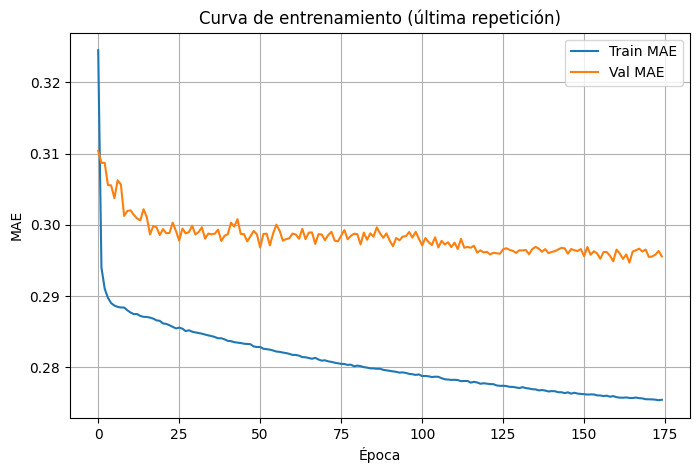

In [ ]:
historia_dict = historia.history

plt.figure(figsize=(8, 5))
plt.plot(historia_dict['mae'], label='Train MAE')
plt.plot(historia_dict['val_mae'], label='Val MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Curva de entrenamiento (última repetición)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
importances = permutation_importance(modelo_mlp, X_val_scaled, y_val)
for name, imp in zip(variables_predictoras, importances):
    print(f"{name}: {imp:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
238/238 ━━━━━━━━

In [ ]:
importancia_df = pd.DataFrame({
    'variable': variables_predictoras,
    'importancia': importances
})

pd.set_option('display.max_rows', None)
importancia_df = importancia_df.sort_values(by='importancia', ascending=False)

importancia_df

,variable,importancia
35,mean_wind_speed,0.073741
36,mean_wind_cubed,0.032665
18,u100_punto_16,0.008143
17,u100_punto_15,0.007278
31,v100_punto_13,0.006216
16,u100_punto_14,0.006093
25,v100_punto_7,0.006069
28,v100_punto_10,0.005903
33,v100_punto_15,0.005894
32,v100_punto_14,0.005407


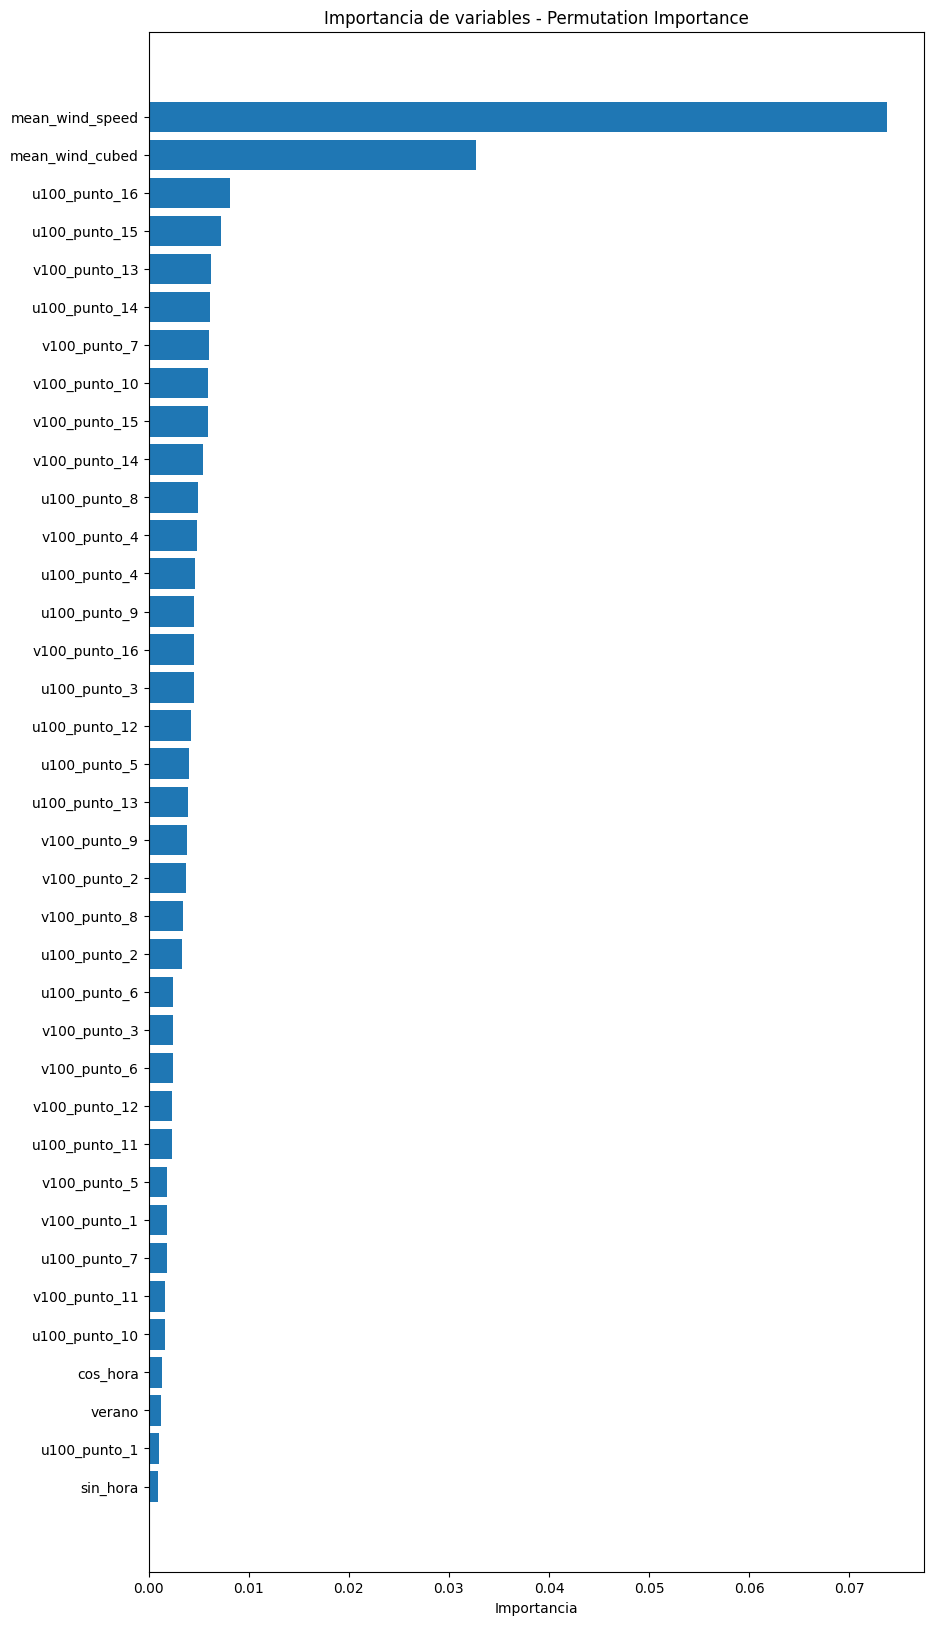

In [ ]:
importancia_df.sort_values(by='importancia', ascending=False, inplace=True)
plt.figure(figsize=(10, 20))
plt.barh(importancia_df['variable'], importancia_df['importancia'])
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de variables - Permutation Importance')
plt.show()

# Optuna sobre el modelo escogido (solo parámetros)

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.6 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)

    hidden_layers = []
    dropouts = []

    for i in range(n_layers):
        units = trial.suggest_int(f'units_layer_{i+1}', 32, 256, step=32)
        reg_type = trial.suggest_categorical(f"reg_type_{i+1}", ["none", "l1", "l2", "dropout"])

        if reg_type == "l1":
            kernel_reg = l1(trial.suggest_float(f"l1_{i+1}", 1e-6, 1e-2, log=True))
            dropout = 0.0
        elif reg_type == "l2":
            kernel_reg = l2(trial.suggest_float(f"l2_{i+1}", 1e-6, 1e-2, log=True))
            dropout = 0.0
        elif reg_type == "dropout":
            kernel_reg = None
            dropout = trial.suggest_float(f"dropout_{i+1}", 0.1, 0.4, step=0.1)
        else:
            kernel_reg = None
            dropout = 0.0

        hidden_layers.append((units, kernel_reg))
        dropouts.append(dropout)

    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    patience = 10

    val_maes = []

    for i in range(3):
        semilla = np.random.randint(0, 10000)
        set_seeds(semilla)

        model = Sequential()
        model.add(Input(shape=(X_train_scaled.shape[1],)))

        for (units, reg), dropout in zip(hidden_layers, dropouts):
            model.add(Dense(units, activation='relu', kernel_regularizer=reg))
            if dropout > 0:
                model.add(Dropout(dropout))

        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae', metrics=['mae'])

        early_stop = EarlyStopping(patience=patience, restore_best_weights=True)
        pruning_cb = TFKerasPruningCallback(trial, "val_mae")

        model.fit(
            X_train_scaled, y_train_scaled,
            validation_data=(X_val_scaled, y_val_scaled),
            epochs=1000,
            batch_size=batch_size,
            callbacks=[early_stop, pruning_cb],
            verbose=0
        )

        y_pred_scaled = model.predict(X_val_scaled, verbose=0).flatten()
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        mae = mean_absolute_error(y_val, y_pred)
        val_maes.append(mae)

    return np.mean(val_maes)

In [ ]:
study = optuna.create_study(
    direction='minimize',
    study_name='MLP parámetros finales',
    storage='sqlite:///optuna_estudio_MLP.db',
    load_if_exists=True
)

study.optimize(objective, n_trials=200)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print("Mejor MAE de validación: ", study.best_value)

[I 2025-06-03 21:04:11,533] A new study created in RDB with name: MLP parámetros finales
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/optuna/trial/_tr

Mejores hiperparámetros encontrados:
{'n_layers': 2, 'units_layer_1': 224, 'reg_type_1': 'l1', 'l1_1': 1.755099064611389e-05, 'units_layer_2': 128, 'reg_type_2': 'l2', 'l2_2': 0.0033981399467863365, 'learning_rate': 0.00013132201859702034, 'batch_size': 64}
Mejor MAE de validación:  0.06754783176974194


Mejores hiperparámetros encontrados:
{'n_layers': 2, 'units_layer_1': 224, 'reg_type_1': 'l1', 'l1_1': 1.755099064611389e-05, 'units_layer_2': 128, 'reg_type_2': 'l2', 'l2_2': 0.0033981399467863365, 'learning_rate': 0.00013132201859702034, 'batch_size': 64}
Mejor MAE de validación:  0.06754783176974194

## Definición del modelo optuna

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n 🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(256, activation='relu', kernel_regularizer=l2(8.400451767968019e-05)),
        Dense(96, activation='relu', kernel_regularizer=l1( 0.0006107047994116768)),
        Dense(64, activation='relu', kernel_regularizer=l2( 0.00022882026942074295)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.00012887933098133794)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')


df_resultados = pd.DataFrame(resultados)
print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0664 | Val: 0.0675 | Test: 0.0700

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0664 ± nan
val_mae         = 0.0675 ± nan
test_mae        = 0.0700 ± nan
test_rmse       = 0.1046 ± nan
test_mse        = 0.0109 ± nan


In [ ]:
num_epocas_entrenadas = len(historia.history['loss'])
print(f'Se entrenó durante {num_epocas_entrenadas} épocas antes del EarlyStopping.')

Se entrenó durante 100 épocas antes del EarlyStopping.


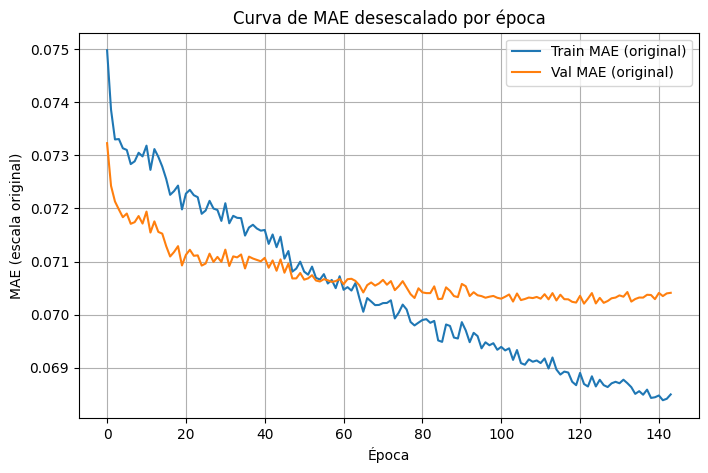

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(mae_original_callback.train_mae_original, label='Train MAE (original)')
plt.plot(mae_original_callback.val_mae_original, label='Val MAE (original)')
plt.xlabel('Época')
plt.ylabel('MAE (escala original)')
plt.title('Curva de MAE desescalado por época')
plt.legend()
plt.grid(True)
plt.show()

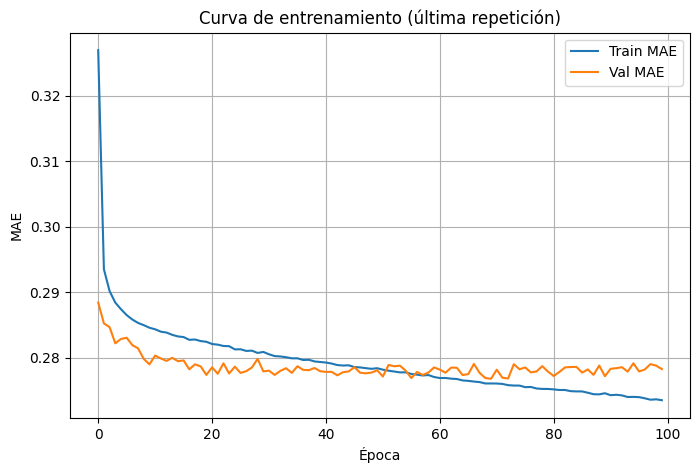

In [ ]:
historia_dict = historia.history
plt.figure(figsize=(8, 5))
plt.plot(historia_dict['mae'], label='Train MAE')
plt.plot(historia_dict['val_mae'], label='Val MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('Curva de entrenamiento (última repetición)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def permutation_importance(model, X_val, y_val, metric=mean_absolute_error, n_repeats=5):
    baseline = metric(y_val, scaler_y.inverse_transform(model.predict(X_val)))
    importances = []

    for i in range(X_val.shape[1]):
        scores = []
        X_val_permuted = X_val.copy()
        for _ in range(n_repeats):
            np.random.shuffle(X_val_permuted[:, i])
            y_pred = scaler_y.inverse_transform(model.predict(X_val_permuted))
            score = metric(y_val, y_pred)
            scores.append(score)
        importance = np.mean(scores) - baseline
        importances.append(importance)

    return np.array(importances)

In [ ]:
importances = permutation_importance(modelo_mlp, X_val_scaled, y_val)
for name, imp in zip(variables_predictoras, importances):
    print(f"{name}: {imp:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━

In [ ]:
importancia_df = pd.DataFrame({
    'variable': variables_predictoras,
    'importancia': importances
})
pd.set_option('display.max_rows', None)
importancia_df = importancia_df.sort_values(by='importancia', ascending=False)

importancia_df

,variable,importancia
50,wind_speed_punto_13,0.015015
69,wind_cubed_punto_16,0.013708
53,wind_speed_punto_16,0.008056
54,wind_cubed_punto_1,0.007582
63,wind_cubed_punto_10,0.006850
61,wind_cubed_punto_8,0.006755
38,wind_speed_punto_1,0.006373
66,wind_cubed_punto_13,0.005903
56,wind_cubed_punto_3,0.005815
52,wind_speed_punto_15,0.003862


In [ ]:
pd.reset_option('display.max_rows')

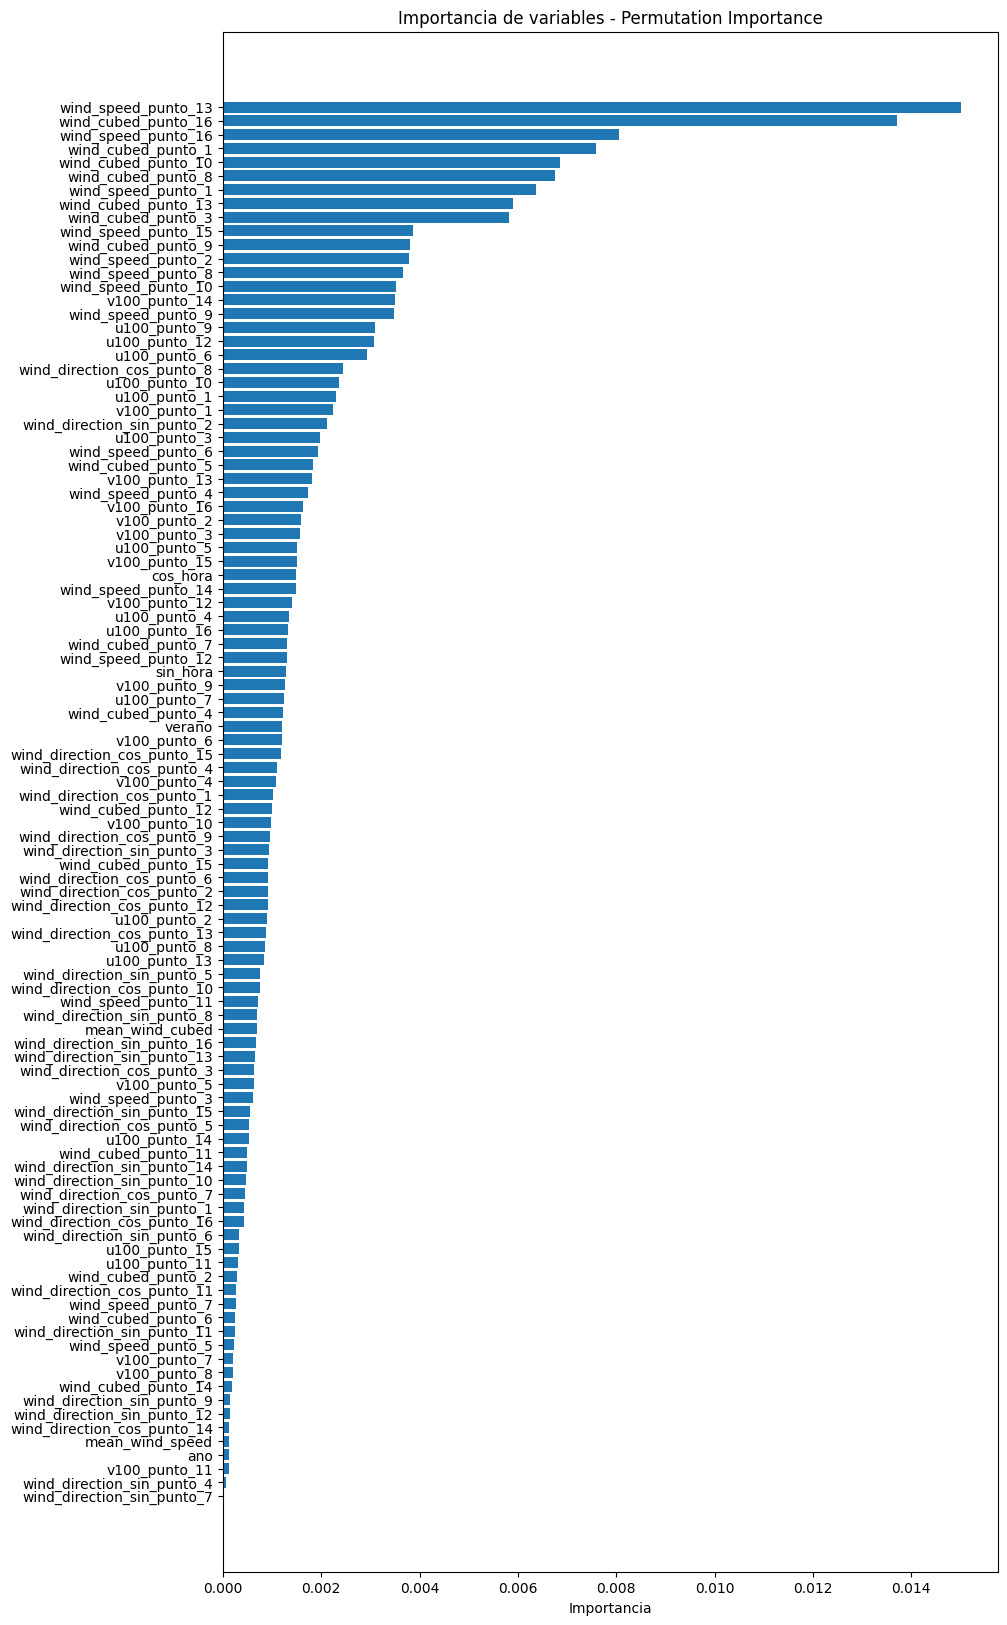

In [ ]:
importancia_df.sort_values(by='importancia', ascending=False, inplace=True)
plt.figure(figsize=(10, 20))
plt.barh(importancia_df['variable'], importancia_df['importancia'])
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de variables - Permutation Importance')
plt.show()

# Optuna sobre el modelo escogido (parámetros y variables)

In [ ]:
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler_X.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=X_test.columns, index=X_test.index)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
def objective(trial):
    # Selección de variables predictoras (sin sin_hora y cos_hora)
    selected_features = [
        var for var in variables_predictoras
        if var not in ['sin_hora', 'cos_hora'] and trial.suggest_categorical(var, [True, False])
    ]

    # Añado sin_hora y cos_hora si se decide usarlas
    if trial.suggest_categorical("use_hora", [True, False]):
        selected_features += ['sin_hora', 'cos_hora']

    if len(selected_features) == 0:
        return float('inf')

    n_layers = trial.suggest_int("n_layers", 1, 3)

    hidden_layers = []
    dropouts = []

    for i in range(n_layers):
        units = trial.suggest_int(f'units_layer_{i+1}', 32, 256, step=32)
        reg_type = trial.suggest_categorical(f"reg_type_{i+1}", ["none", "l1", "l2", "dropout"])

        if reg_type == "l1":
            kernel_reg = l1(trial.suggest_float(f"l1_{i+1}", 1e-6, 1e-2, log=True))
            dropout = 0.0
        elif reg_type == "l2":
            kernel_reg = l2(trial.suggest_float(f"l2_{i+1}", 1e-6, 1e-2, log=True))
            dropout = 0.0
        elif reg_type == "dropout":
            kernel_reg = None
            dropout = trial.suggest_float(f"dropout_{i+1}", 0.1, 0.4, step=0.1)
        else:  # none
            kernel_reg = None
            dropout = 0.0

        hidden_layers.append((units, kernel_reg))
        dropouts.append(dropout)

    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    patience = 10

    val_maes = []

    for i in range(3):
        semilla = np.random.randint(0, 10000)
        set_seeds(semilla)

        model = Sequential()
        model.add(Input(shape=(len(selected_features),)))

        for (units, reg), dropout in zip(hidden_layers, dropouts):
            model.add(Dense(units, activation='relu', kernel_regularizer=reg))
            if dropout > 0:
                model.add(Dropout(dropout))

        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae', metrics=['mae'])

        early_stop = EarlyStopping(patience=patience, restore_best_weights=True)
        pruning_cb = TFKerasPruningCallback(trial, "val_mae")

        model.fit(
            X_train_scaled[selected_features], y_train_scaled,
            validation_data=(X_val_scaled[selected_features], y_val_scaled),
            epochs=10000,
            batch_size=batch_size,
            callbacks=[early_stop, pruning_cb],
            verbose=0
        )

        y_pred_scaled = model.predict(X_val_scaled[selected_features], verbose=0).flatten()
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        mae = mean_absolute_error(y_val, y_pred)
        val_maes.append(mae)

    return np.mean(val_maes)

In [ ]:
study = optuna.create_study(
    direction='minimize',
    study_name='MLP parámetros y variables finales',
    storage='sqlite:///optuna_estudio_MLP.db',
    load_if_exists=True
)

study.optimize(objective, n_trials=200)
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print("Mejor MAE de validación: ", study.best_value)

# Número de iteraciones: 200

[I 2025-06-04 21:13:15,054] Using an existing study with name 'MLP parámetros y variables finales' instead of creating a new one.
[I 2025-06-04 21:13:34,134] Trial 122 pruned. Trial was pruned at epoch 0.
[I 2025-06-04 21:13:45,352] Trial 123 pruned. Trial was pruned at epoch 0.
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.11/dist-packa

Mejores hiperparámetros encontrados:
{'u100_punto_10_lag-1': True, 'u100_punto_10_lag0': True, 'u100_punto_10_lag1': False, 'u100_punto_11_lag-1': True, 'u100_punto_11_lag0': True, 'u100_punto_11_lag1': False, 'u100_punto_12_lag-1': True, 'u100_punto_12_lag0': False, 'u100_punto_12_lag1': True, 'u100_punto_13_lag-1': True, 'u100_punto_13_lag0': False, 'u100_punto_13_lag1': False, 'u100_punto_14_lag-1': False, 'u100_punto_14_lag0': False, 'u100_punto_14_lag1': True, 'u100_punto_15_lag-1': True, 'u100_punto_15_lag0': True, 'u100_punto_15_lag1': True, 'u100_punto_16_lag-1': True, 'u100_punto_16_lag0': False, 'u100_punto_16_lag1': False, 'u100_punto_9_lag-1': True, 'u100_punto_9_lag0': False, 'u100_punto_9_lag1': True, 'v100_punto_10_lag-1': True, 'v100_punto_10_lag0': True, 'v100_punto_10_lag1': False, 'v100_punto_11_lag-1': False, 'v100_punto_11_lag0': False, 'v100_punto_11_lag1': False, 'v100_punto_12_lag-1': True, 'v100_punto_12_lag0': True, 'v100_punto_12_lag1': False, 'v100_punto_13_

# Definición y evaluación del modelo definitivo

In [31]:
variables_predictoras = [
    'u100_punto_10_lag-1',
    'u100_punto_10_lag0',
    'u100_punto_11_lag-1',
    'u100_punto_11_lag0',
    'u100_punto_12_lag-1',
    'u100_punto_12_lag1',
    'u100_punto_13_lag-1',
    'u100_punto_14_lag1',
    'u100_punto_15_lag-1',
    'u100_punto_15_lag0',
    'u100_punto_15_lag1',
    'u100_punto_16_lag-1',
    'u100_punto_9_lag-1',
    'u100_punto_9_lag1',
    'v100_punto_10_lag-1',
    'v100_punto_10_lag0',
    'v100_punto_12_lag-1',
    'v100_punto_12_lag0',
    'v100_punto_13_lag-1',
    'v100_punto_13_lag1',
    'v100_punto_15_lag1',
    'v100_punto_16_lag0',
    'v100_punto_9_lag0',
    'v100_punto_9_lag1',
    'mean_wind_speed_lag0',
    'mean_wind_speed_lag1',
    'mean_wind_cubed_lag-1'
]

In [32]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [33]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [34]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(192, activation='relu'),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0010855804507576602)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001249202270638142)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    y_train_pred = scaler_y.inverse_transform(modelo_mlp.predict(X_train_scaled))
    y_val_pred = scaler_y.inverse_transform(modelo_mlp.predict(X_val_scaled))
    y_test_pred = scaler_y.inverse_transform(modelo_mlp.predict(X_test_scaled))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)
    test_rmse = np.sqrt(test_mse)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'test_r2': test_r2,
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')
    print(f'     RMSE Train: {train_rmse:.4f} | Val: {val_rmse:.4f} | Test: {test_rmse:.4f}')
    print(f'     MSE Train: {train_mse:.4f} | Val: {val_mse:.4f} | Test: {test_mse:.4f}')
    print(f'     R²   Train: {train_r2:.4f} | Val: {val_r2:.4f} | Test: {test_r2:.4f}')

df_resultados = pd.DataFrame(resultados)

print("\n📌 RESULTADOS PROMEDIO sobre 5 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')



🔁 Repetición 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0700 | Val: 0.0688 | Test: 0.0696
     RMSE Train: 0.1057 | Val: 0.1043 | Test: 0.1043
     MSE Train: 0.0112 | Val: 0.0109 | Test: 0.0109
     R²   Train: 0.8142 | Val: 0.8236 | Test: 0.8228

🔁 Repetición 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0696 | Val: 0.0681 | Test: 0.0696
     RMSE Train: 0.1047 | Val: 0.1028 | Test: 0.1037
     MSE Train: 0.0110 | Val: 0.0106 | Test: 0.0108
     R²   Train: 0.8177 | Val: 0.8285 | Test: 0.8248

🔁 Repetición 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0694 | Val: 0.0684 | Test: 0.0696
     RMSE Train: 0.1046 | Val: 0.1035 | Test: 0.1036
     MSE Train: 0.0109 | Val: 0.0107 | Test: 0.0107
   

In [ ]:
len(variables_predictoras)

27

A partir de ahora, defino el modelo fijando una semilla, para que los resultados sean reproducibles:

In [35]:
resultados = []

semilla = 42
set_seeds(semilla)

modelo_mlp = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(192, activation='relu'),
    Dense(128, activation='relu', kernel_regularizer=l2( 0.0010855804507576602)),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0001249202270638142)
modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
mae_original_callback = MAEOriginalCallback(X_train_scaled, y_train, X_val_scaled, y_val, scaler_y)

historia = modelo_mlp.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=1000,
    batch_size=32,
    callbacks= [early_stop, mae_original_callback],
    verbose=0
)

y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mse = mean_squared_error(y_test, y_test_pred)

resultados.append({
    'train_mae': train_mae,
    'val_mae': val_mae,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_mse': test_mse
})

print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')

df_resultados = pd.DataFrame(resultados)

# print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
  avg = df_resultados[col].mean()
  std = df_resultados[col].std()
  print(f'{col:<15} = {avg:.4f}')

1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0700 | Val: 0.0684 | Test: 0.0696
train_mae       = 0.0700
val_mae         = 0.0684
test_mae        = 0.0696
test_rmse       = 0.1039
test_mse        = 0.0108


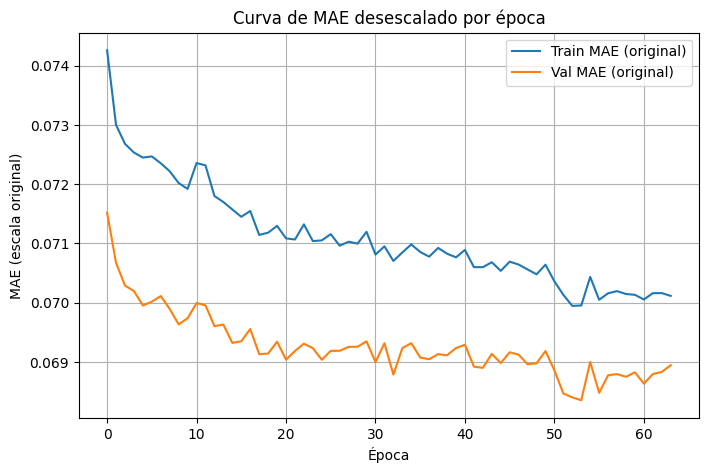

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(mae_original_callback.train_mae_original, label='Train MAE (original)')
plt.plot(mae_original_callback.val_mae_original, label='Val MAE (original)')
plt.xlabel('Época')
plt.ylabel('MAE (escala original)')
plt.title('Curva de MAE desescalado por época')
plt.legend()
plt.grid(True)
plt.show()

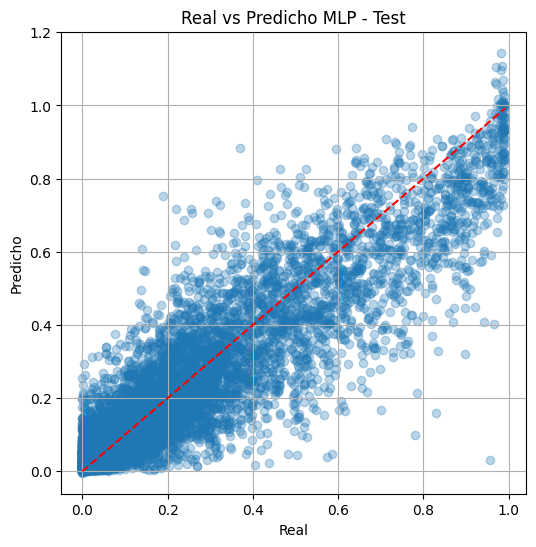

In [37]:
def plot_real_vs_pred_mlp(y_true, y_pred, title=""):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"Real vs Predicho MLP - {title}")
    plt.grid(True)
    plt.show()

plot_real_vs_pred_mlp(y_test, y_test_pred.flatten(), "Test")

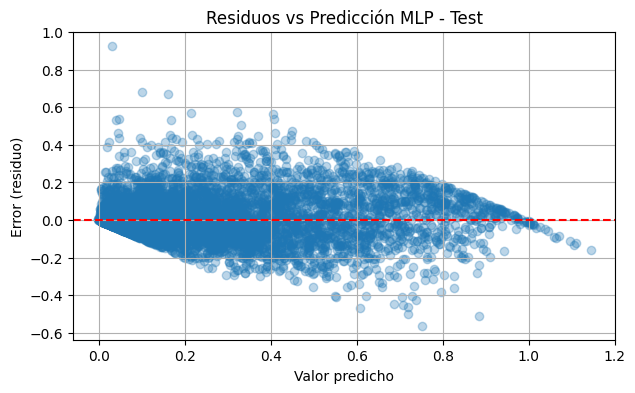

In [38]:
def plot_residuos_mlp(y_true, y_pred, title=""):
    residuos = y_true - y_pred
    plt.figure(figsize=(7, 4))
    plt.scatter(y_pred, residuos, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Valor predicho")
    plt.ylabel("Error (residuo)")
    plt.title(f"Residuos vs Predicción MLP - {title}")
    plt.grid(True)
    plt.show()

plot_residuos_mlp(y_test, y_test_pred.flatten(), "Test")

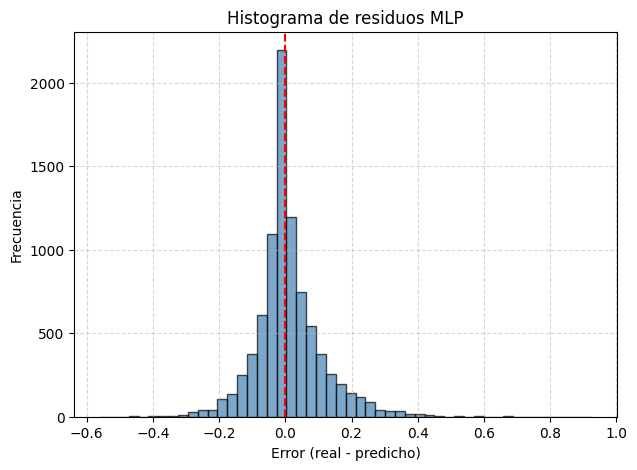

In [44]:
residuos_test = y_test - y_test_pred.flatten()
# Histograma
plt.figure(figsize=(7, 5))
plt.hist(residuos_test, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histograma de residuos MLP")
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [45]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def permutation_importance(model, X_val, y_val, metric=mean_absolute_error, n_repeats=5):
    baseline = metric(y_val, scaler_y.inverse_transform(model.predict(X_val)))
    importances = []

    for i in range(X_val.shape[1]):
        scores = []
        X_val_permuted = X_val.copy()
        for _ in range(n_repeats):
            np.random.shuffle(X_val_permuted[:, i])
            y_pred = scaler_y.inverse_transform(model.predict(X_val_permuted))
            score = metric(y_val, y_pred)
            scores.append(score)
        importance = np.mean(scores) - baseline
        importances.append(importance)

    return np.array(importances)

In [46]:
importances = permutation_importance(modelo_mlp, X_val_scaled, y_val)
for name, imp in zip(variables_predictoras, importances):
    print(f"{name}: {imp:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━

In [47]:
importancia_df = pd.DataFrame({
    'variable': variables_predictoras,
    'importancia': importances
})

pd.set_option('display.max_rows', None)
importancia_df = importancia_df.sort_values(by='importancia', ascending=False)

importancia_df

,variable,importancia
25,mean_wind_speed_lag1,0.037157
24,mean_wind_speed_lag0,0.020976
26,mean_wind_cubed_lag-1,0.019633
18,v100_punto_13_lag-1,0.015232
6,u100_punto_13_lag-1,0.013475
4,u100_punto_12_lag-1,0.010480
14,v100_punto_10_lag-1,0.009956
20,v100_punto_15_lag1,0.009868
21,v100_punto_16_lag0,0.009166
9,u100_punto_15_lag0,0.008582


In [48]:
pd.reset_option('display.max_rows')

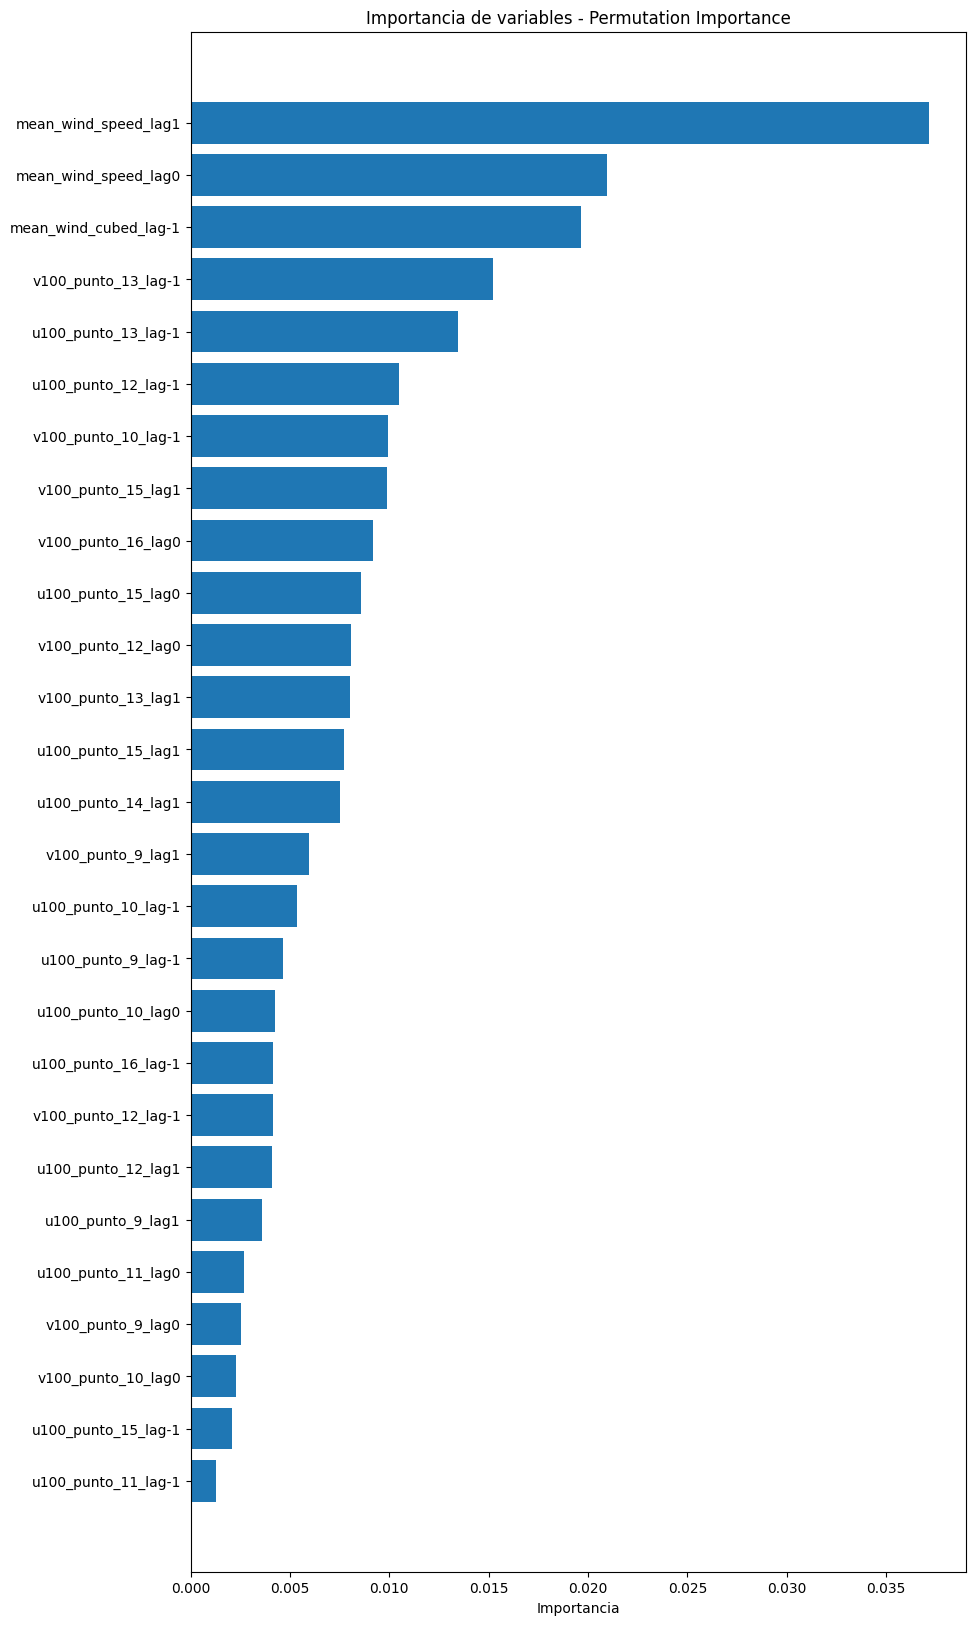

In [49]:
import matplotlib.pyplot as plt

importancia_df.sort_values(by='importancia', ascending=False, inplace=True)
plt.figure(figsize=(10, 20))
plt.barh(importancia_df['variable'], importancia_df['importancia'])
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de variables - Permutation Importance')
plt.show()

# Modelo sin medias

Pruebo ahora el modelo sin las medias, que son las variables que más importancia tienen, para ver si el modelo tiene también una buena capacidad de predicción aunque no utilice esas variables.

In [50]:
variables_predictoras = [
    'u100_punto_10_lag-1',
    'u100_punto_10_lag0',
    'u100_punto_11_lag-1',
    'u100_punto_11_lag0',
    'u100_punto_12_lag-1',
    'u100_punto_12_lag1',
    'u100_punto_13_lag-1',
    'u100_punto_14_lag1',
    'u100_punto_15_lag-1',
    'u100_punto_15_lag0',
    'u100_punto_15_lag1',
    'u100_punto_16_lag-1',
    'u100_punto_9_lag-1',
    'u100_punto_9_lag1',
    'v100_punto_10_lag-1',
    'v100_punto_10_lag0',
    'v100_punto_12_lag-1',
    'v100_punto_12_lag0',
    'v100_punto_13_lag-1',
    'v100_punto_13_lag1',
    'v100_punto_15_lag1',
    'v100_punto_16_lag0',
    'v100_punto_9_lag0',
    'v100_punto_9_lag1'
    # 'mean_wind_speed_lag0',
    # 'mean_wind_speed_lag1',
    # 'mean_wind_cubed_lag-1'
]

In [51]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [52]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43500 filas
Val: 7600 filas


In [53]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [28]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/3')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(192, activation='relu'),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0010855804507576602)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001249202270638142)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    y_train_pred = scaler_y.inverse_transform(modelo_mlp.predict(X_train_scaled))
    y_val_pred = scaler_y.inverse_transform(modelo_mlp.predict(X_val_scaled))
    y_test_pred = scaler_y.inverse_transform(modelo_mlp.predict(X_test_scaled))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)
    test_rmse = np.sqrt(test_mse)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'test_r2': test_r2,
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')
    print(f'     RMSE Train: {train_rmse:.4f} | Val: {val_rmse:.4f} | Test: {test_rmse:.4f}')
    print(f'     MSE Train: {train_mse:.4f} | Val: {val_mse:.4f} | Test: {test_mse:.4f}')
    print(f'     R²   Train: {train_r2:.4f} | Val: {val_r2:.4f} | Test: {test_r2:.4f}')

df_resultados = pd.DataFrame(resultados)

print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')



🔁 Repetición 1/3
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0708 | Val: 0.0701 | Test: 0.0723
     RMSE Train: 0.1068 | Val: 0.1066 | Test: 0.1088
     MSE Train: 0.0114 | Val: 0.0114 | Test: 0.0118
     R²   Train: 0.8100 | Val: 0.8157 | Test: 0.8073

🔁 Repetición 2/3
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0704 | Val: 0.0695 | Test: 0.0711
     RMSE Train: 0.1058 | Val: 0.1053 | Test: 0.1062
     MSE Train: 0.0112 | Val: 0.0111 | Test: 0.0113
     R²   Train: 0.8137 | Val: 0.8202 | Test: 0.8166

🔁 Repetición 3/3
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0718 | Val: 0.0711 | Test: 0.0716
     RMSE Train: 0.1072 | Val: 0.1075 | Test: 0.1064
     MSE Train: 0.0115 | Val: 0.0116 | Test: 0.0113
   

In [29]:
len(variables_predictoras)

24

A partir de ahora, defino el modelo fijando una semilla, para que los resultados sean reproducibles:

In [55]:
resultados = []

semilla = 42
set_seeds(semilla)

modelo_mlp = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(192, activation='relu'),
    Dense(128, activation='relu', kernel_regularizer=l2( 0.0010855804507576602)),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0001249202270638142)
modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
mae_original_callback = MAEOriginalCallback(X_train_scaled, y_train, X_val_scaled, y_val, scaler_y)

historia = modelo_mlp.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=1000,
    batch_size=32,
    callbacks= [early_stop, mae_original_callback],
    verbose=0
)

y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mse = mean_squared_error(y_test, y_test_pred)

resultados.append({
    'train_mae': train_mae,
    'val_mae': val_mae,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_mse': test_mse
})

print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')

df_resultados = pd.DataFrame(resultados)

# print("\n📌 RESULTADOS PROMEDIO sobre 3 repeticiones:")
for col in df_resultados.columns:
  avg = df_resultados[col].mean()
  std = df_resultados[col].std()
  print(f'{col:<15} = {avg:.4f}')

1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📊 MAE Train: 0.0714 | Val: 0.0707 | Test: 0.0713
train_mae       = 0.0714
val_mae         = 0.0707
test_mae        = 0.0713
test_rmse       = 0.1063
test_mse        = 0.0113


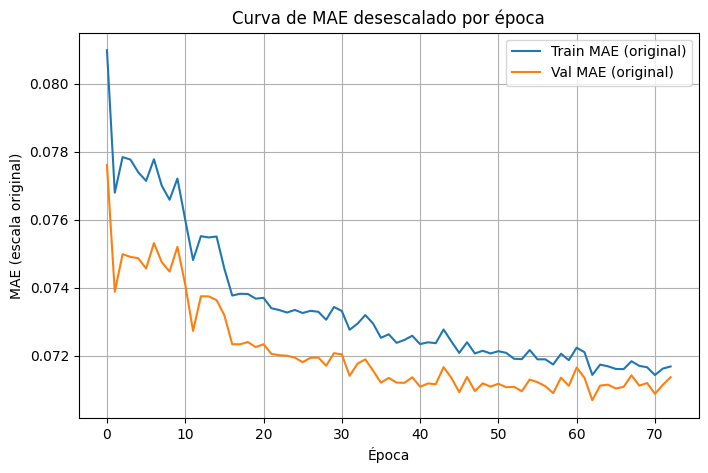

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(mae_original_callback.train_mae_original, label='Train MAE (original)')
plt.plot(mae_original_callback.val_mae_original, label='Val MAE (original)')
plt.xlabel('Época')
plt.ylabel('MAE (escala original)')
plt.title('Curva de MAE desescalado por época')
plt.legend()
plt.grid(True)
plt.show()

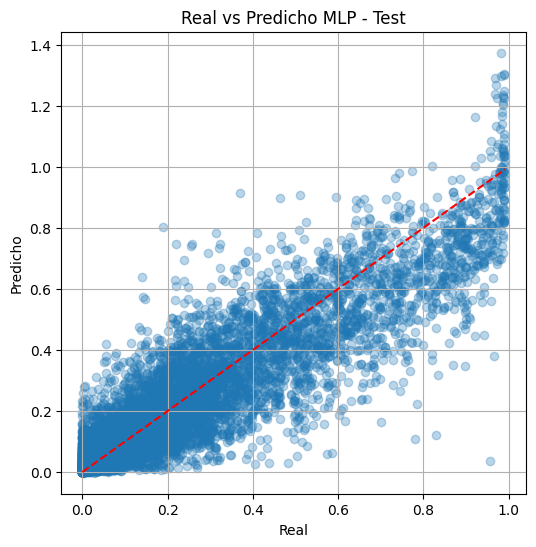

In [57]:
def plot_real_vs_pred_mlp(y_true, y_pred, title=""):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"Real vs Predicho MLP - {title}")
    plt.grid(True)
    plt.show()

plot_real_vs_pred_mlp(y_test, y_test_pred.flatten(), "Test")


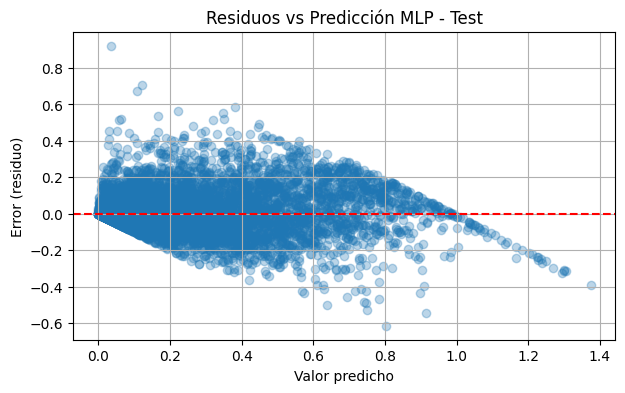

In [58]:
def plot_residuos_mlp(y_true, y_pred, title=""):
    residuos = y_true - y_pred
    plt.figure(figsize=(7, 4))
    plt.scatter(y_pred, residuos, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Valor predicho")
    plt.ylabel("Error (residuo)")
    plt.title(f"Residuos vs Predicción MLP - {title}")
    plt.grid(True)
    plt.show()

plot_residuos_mlp(y_test, y_test_pred.flatten(), "Test")

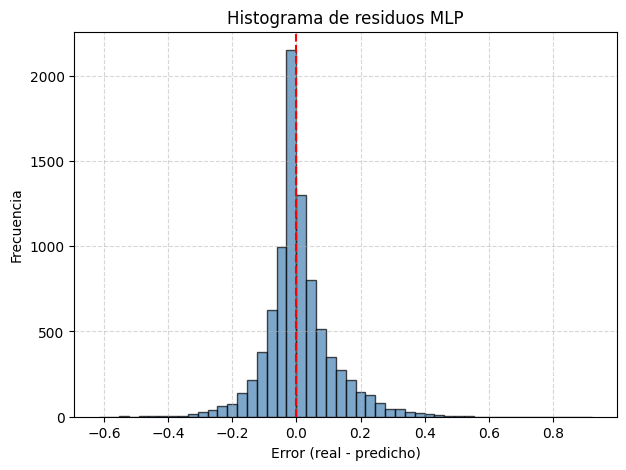

In [59]:
residuos_test = y_test - y_test_pred.flatten()
# Histograma
plt.figure(figsize=(7, 5))
plt.hist(residuos_test, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histograma de residuos MLP")
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def permutation_importance(model, X_val, y_val, metric=mean_absolute_error, n_repeats=5):
    baseline = metric(y_val, scaler_y.inverse_transform(model.predict(X_val)))
    importances = []

    for i in range(X_val.shape[1]):
        scores = []
        X_val_permuted = X_val.copy()
        for _ in range(n_repeats):
            np.random.shuffle(X_val_permuted[:, i])
            y_pred = scaler_y.inverse_transform(model.predict(X_val_permuted))
            score = metric(y_val, y_pred)
            scores.append(score)
        importance = np.mean(scores) - baseline
        importances.append(importance)

    return np.array(importances)

In [61]:
importances = permutation_importance(modelo_mlp, X_val_scaled, y_val)
for name, imp in zip(variables_predictoras, importances):
    print(f"{name}: {imp:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
238/238 ━━━━━━━━

In [62]:
importancia_df = pd.DataFrame({
    'variable': variables_predictoras,
    'importancia': importances
})

pd.set_option('display.max_rows', None)
importancia_df = importancia_df.sort_values(by='importancia', ascending=False)

importancia_df

,variable,importancia
9,u100_punto_15_lag0,0.020747
20,v100_punto_15_lag1,0.018834
6,u100_punto_13_lag-1,0.016883
5,u100_punto_12_lag1,0.015740
0,u100_punto_10_lag-1,0.013082
13,u100_punto_9_lag1,0.012111
18,v100_punto_13_lag-1,0.012093
11,u100_punto_16_lag-1,0.011745
23,v100_punto_9_lag1,0.010440
21,v100_punto_16_lag0,0.008041


In [63]:
pd.reset_option('display.max_rows')

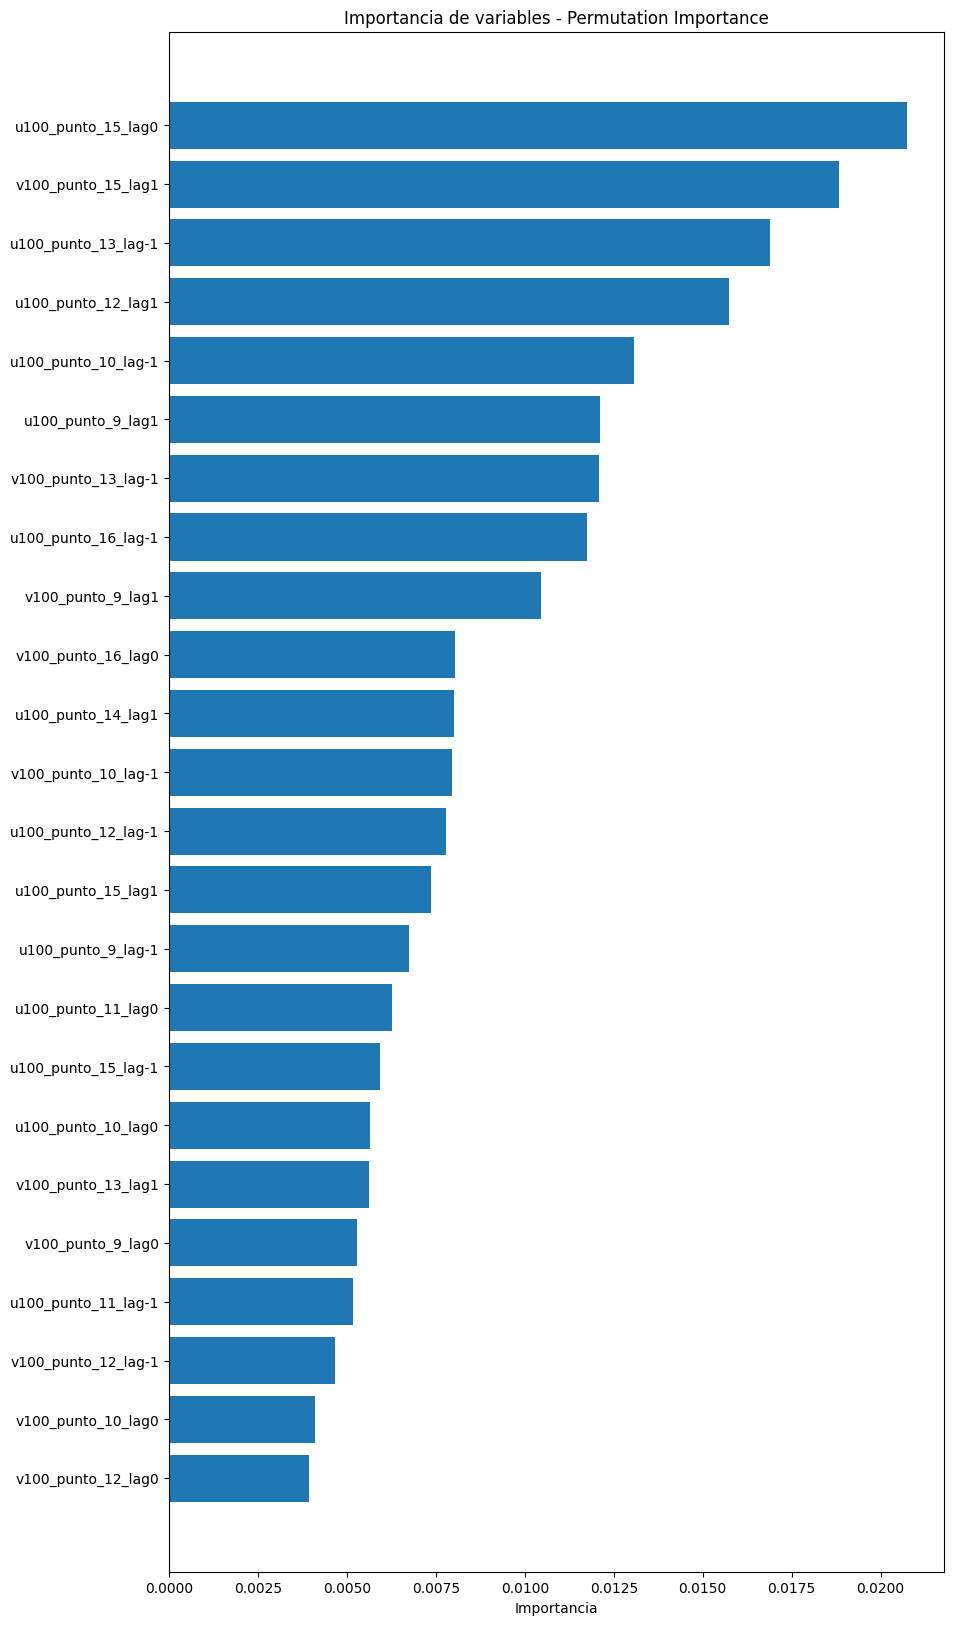

In [64]:
import matplotlib.pyplot as plt

importancia_df.sort_values(by='importancia', ascending=False, inplace=True)
plt.figure(figsize=(10, 20))
plt.barh(importancia_df['variable'], importancia_df['importancia'])
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de variables - Permutation Importance')
plt.show()

# MLP si se utiliza para predecir hora por hora

## Compruebo cuántas horas anteriores ayudan

In [ ]:
df_completo['lag_1'] = df_completo['Tanto por 1'].shift(1)
df_completo['lag_2'] = df_completo['Tanto por 1'].shift(2)
df_completo['lag_3'] = df_completo['Tanto por 1'].shift(3)
df_completo['lag_4'] = df_completo['Tanto por 1'].shift(4)
df_completo['lag_5'] = df_completo['Tanto por 1'].shift(5)
df_completo['lag_6'] = df_completo['Tanto por 1'].shift(6)
df_completo['lag_7'] = df_completo['Tanto por 1'].shift(7)
df_completo['lag_8'] = df_completo['Tanto por 1'].shift(8)
df_completo['lag_9'] = df_completo['Tanto por 1'].shift(9)
df_completo['lag_10'] = df_completo['Tanto por 1'].shift(10)

In [ ]:
df_completo = df_completo.dropna()

In [ ]:
df_test = df_completo[df_completo['time'].dt.year == 2022]
df_trainval = df_completo[df_completo['time'].dt.year != 2022]

In [ ]:
# Para evitar filtrado de información:
df_2023 = df_trainval[df_trainval["time"].dt.year == 2023]
indices_a_eliminar = df_2023.index[:10]
df_trainval = df_trainval.drop(index=indices_a_eliminar)

In [ ]:
variables_predictoras = [
    'u100_punto_10_lag-1',
    'u100_punto_10_lag0',
    'u100_punto_11_lag-1',
    'u100_punto_11_lag0',
    'u100_punto_12_lag-1',
    'u100_punto_12_lag1',
    'u100_punto_13_lag-1',
    'u100_punto_14_lag1',
    'u100_punto_15_lag-1',
    'u100_punto_15_lag0',
    'u100_punto_15_lag1',
    'u100_punto_16_lag-1',
    'u100_punto_9_lag-1',
    'u100_punto_9_lag1',
    'v100_punto_10_lag-1',
    'v100_punto_10_lag0',
    'v100_punto_12_lag-1',
    'v100_punto_12_lag0',
    'v100_punto_13_lag-1',
    'v100_punto_13_lag1',
    'v100_punto_15_lag1',
    'v100_punto_16_lag0',
    'v100_punto_9_lag0',
    'v100_punto_9_lag1',
    'mean_wind_speed_lag0',
    'mean_wind_speed_lag1',
    'mean_wind_cubed_lag-1',
    'lag_1',
    'lag_2',
    'lag_3',
    'lag_4',
    'lag_5',
    'lag_6',
    'lag_7',
    'lag_8',
    'lag_9',
    'lag_10'
]
objetivo = ['Tanto por 1']

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43400 filas
Val: 7600 filas


In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for max_lag in range(1, 11):  # desde lag_1 hasta lag_10
    print(f"\n================= Probando hasta lag_{max_lag} =================")

    lags_incluidos = [f'lag_{i}' for i in range(1, max_lag + 1)]
    variables_predictoras_con_lags = [col for col in variables_predictoras if not col.startswith('lag_')] + lags_incluidos

    X_train_sub = X_train[variables_predictoras_con_lags]
    X_val_sub   = X_val[variables_predictoras_con_lags]
    X_test_sub  = X_test[variables_predictoras_con_lags]

    scaler_x = StandardScaler()
    X_train_scaled = scaler_x.fit_transform(X_train_sub)
    X_val_scaled   = scaler_x.transform(X_val_sub)
    X_test_scaled  = scaler_x.transform(X_test_sub)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_val_scaled   = scaler_y.transform(y_val.values.reshape(-1, 1))
    y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1))

    maes_test_reps = []

    for i in range(3):
        semilla = np.random.randint(0, 10000)
        set_seeds(semilla)

        modelo_mlp = Sequential([
            Input(shape=(X_train_scaled.shape[1],)),
            Dense(192, activation='relu'),
            Dense(128, activation='relu', kernel_regularizer=l2(0.0010855804507576602)),
            Dense(1)
        ])

        optimizer = Adam(learning_rate=0.0001249202270638142)
        modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

        early_stop = EarlyStopping(patience=10, restore_best_weights=True)

        modelo_mlp.fit(
            X_train_scaled, y_train_scaled,
            validation_data=(X_val_scaled, y_val_scaled),
            epochs=1000,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )

        y_test_pred_scaled = modelo_mlp.predict(X_test_scaled, verbose=0)
        y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
        mae_test = mean_absolute_error(y_test, y_test_pred)

        maes_test_reps.append(mae_test)

    resultados.append({
        'max_lag': max_lag,
        'mae_test_mean': np.mean(maes_test_reps),
        'mae_test_std': np.std(maes_test_reps)
    })

df_resultados = pd.DataFrame(resultados)
print("\n📈 RESULTADOS PROMEDIO POR LAG")
print(df_resultados.to_string(index=False))



================= Probando hasta lag_1 =================

================= Probando hasta lag_2 =================

================= Probando hasta lag_3 =================

================= Probando hasta lag_4 =================

================= Probando hasta lag_5 =================

================= Probando hasta lag_6 =================

================= Probando hasta lag_7 =================

================= Probando hasta lag_8 =================

================= Probando hasta lag_9 =================

================= Probando hasta lag_10 =================

📈 RESULTADOS PROMEDIO POR LAG
 max_lag  mae_test_mean  mae_test_std
       1       0.046321      0.000117
       2       0.045172      0.000158
       3       0.045086      0.000277
       4       0.044979      0.000149
       5       0.045224      0.000427
       6       0.045148      0.000082
       7       0.045287      0.000281
       8       0.045139      0.000293
       9       0.045205      0.000068
      10

In [ ]:
resultados = [
    (0,  0.0699, 0.0001),
    (1, 0.046321, 0.000117),  # MAE con 1 lag y su desviación estándar
    (2, 0.045172, 0.000158),
    (3, 0.045086, 0.000277),
    (4, 0.044979, 0.000149),
    (5, 0.045224, 0.000427),
    (6, 0.045148, 0.000082),
    (7, 0.045287, 0.000281),
    (8, 0.045139, 0.000293),
    (9, 0.045205, 0.000068),
    (10, 0.045428, 0.000333)
]

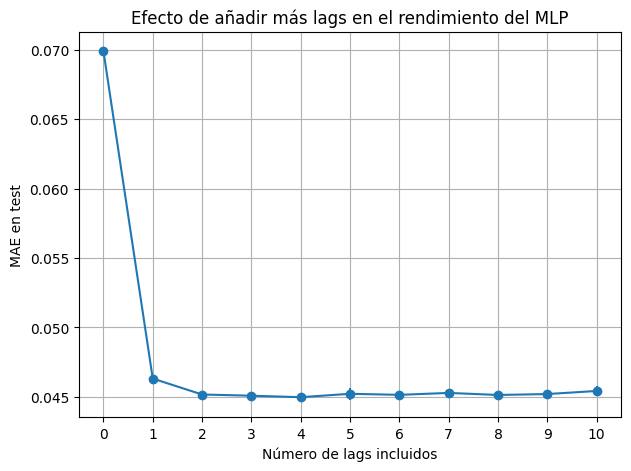

In [ ]:
import matplotlib.pyplot as plt

lags, maes, stds = zip(*resultados)

plt.figure(figsize=(7, 5))

plt.errorbar(lags, maes, yerr=stds, fmt='-o')
plt.xlabel('Número de lags incluidos')
plt.ylabel('MAE en test')
plt.title('Efecto de añadir más lags en el rendimiento del MLP')
plt.xticks(range(0, 11))
plt.grid(True)
plt.show()


## Añado 2 horas anteriores

In [ ]:
df_test = df_completo[df_completo['time'].dt.year == 2022]
df_trainval = df_completo[df_completo['time'].dt.year != 2022]

In [ ]:
df_2023 = df_trainval[df_trainval["time"].dt.year == 2023]
indices_a_eliminar = df_2023.index[:2]
df_trainval = df_trainval.drop(index=indices_a_eliminar)

In [ ]:
total_rows = len(df_completo)
print(f"Train: {len(df_trainval)} filas ({len(df_trainval)/total_rows:.2%})")
print(f"Test: {len(df_test)} filas ({len(df_test)/total_rows:.2%})")

Train: 51091 filas (85.37%)
Test: 8753 filas (14.63%)


In [ ]:
variables_predictoras = [
    'u100_punto_10_lag-1',
    'u100_punto_10_lag0',
    'u100_punto_11_lag-1',
    'u100_punto_11_lag0',
    'u100_punto_12_lag-1',
    'u100_punto_12_lag1',
    'u100_punto_13_lag-1',
    'u100_punto_14_lag1',
    'u100_punto_15_lag-1',
    'u100_punto_15_lag0',
    'u100_punto_15_lag1',
    'u100_punto_16_lag-1',
    'u100_punto_9_lag-1',
    'u100_punto_9_lag1',
    'v100_punto_10_lag-1',
    'v100_punto_10_lag0',
    'v100_punto_12_lag-1',
    'v100_punto_12_lag0',
    'v100_punto_13_lag-1',
    'v100_punto_13_lag1',
    'v100_punto_15_lag1',
    'v100_punto_16_lag0',
    'v100_punto_9_lag0',
    'v100_punto_9_lag1',
    'mean_wind_speed_lag0',
    'mean_wind_speed_lag1',
    'mean_wind_cubed_lag-1',
    'lag_1',
    'lag_2'
]
objetivo = ['Tanto por 1']

In [ ]:
X_trainval = df_trainval[variables_predictoras]
y_trainval = df_trainval['Tanto por 1']

X_test = df_test[variables_predictoras]
y_test = df_test['Tanto por 1']

In [ ]:
block_size = 100
val_fraction = 0.15
n_blocks = len(X_trainval) // block_size
blocks = np.arange(n_blocks)

np.random.seed(42)
np.random.shuffle(blocks)
n_val_blocks = int(n_blocks * val_fraction)
val_blocks = blocks[:n_val_blocks]
train_blocks = blocks[n_val_blocks:]

train_indices = expand_blocks(train_blocks)
val_indices = expand_blocks(val_blocks)

X_train = X_trainval.iloc[train_indices]
y_train = y_trainval.iloc[train_indices]
X_val = X_trainval.iloc[val_indices]
y_val = y_trainval.iloc[val_indices]

print(f"Train: {X_train.shape[0]} filas")
print(f"Val: {X_val.shape[0]} filas")

Train: 43400 filas
Val: 7600 filas


In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
resultados = []

for i in range(3):
    semilla = np.random.randint(0, 10000)
    set_seeds(semilla)
    print(f'\n🔁 Repetición {i+1}/5')

    modelo_mlp = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(192, activation='relu'),
        Dense(128, activation='relu', kernel_regularizer=l2( 0.0010855804507576602)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001249202270638142)
    modelo_mlp.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    historia = modelo_mlp.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=1000,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    y_train_pred_scaled = modelo_mlp.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred_scaled = modelo_mlp.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_test_pred_scaled = modelo_mlp.predict(X_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mse = mean_squared_error(y_test, y_test_pred)

    resultados.append({
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mse': test_mse
    })

    print(f'📊 MAE Train: {train_mae:.4f} | Val: {val_mae:.4f} | Test: {test_mae:.4f}')

df_resultados = pd.DataFrame(resultados)

print("\n📌 RESULTADOS PROMEDIO sobre 5 repeticiones:")
for col in df_resultados.columns:
    avg = df_resultados[col].mean()
    std = df_resultados[col].std()
    print(f'{col:<15} = {avg:.4f} ± {std:.4f}')


🔁 Repetición 1/5
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0445 | Val: 0.0456 | Test: 0.0454

🔁 Repetición 2/5
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
📊 MAE Train: 0.0439 | Val: 0.0452 | Test: 0.0449

🔁 Repetición 3/5
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
📊 MAE Train: 0.0440 | Val: 0.0453 | Test: 0.0452

📌 RESULTADOS PROMEDIO sobre 5 repeticiones:
train_mae       = 0.0442 ± 0.0003
val_mae         = 0.0454 ± 0.0002
test_mae        = 0.0452 ± 0.0003
test_rmse       = 0.0719 ± 0.0002
test_mse        = 0.0052 ± 0.0000
